# DESeq2 analysis with featureCounts meta counts matrix

In [1]:
# loading required packages
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

## I. Load and clean data frames
this includes the featureCounts matrix of meta features and the meta data of the samples (which includes the phase treatment info)

**counts matrix generated from featureCounts (meta features)**

In [2]:
# loading counts matrix
counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_counts.txt', header=TRUE)

# removing the length column
counts <- counts[,-2]

dim(counts) # 38,828 genes total
head(counts)

[1] 38828    31

,GeneID,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,X2018..WBV.WBR.W12.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [3]:
# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_alignment\\.sam$", "", colnames(counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(counts) = cleaned_column_names2
head(counts)

[1] "GeneID"      "BBB.WBO.B21" "BPO.BPO.O16" "WBR.BBY.W25" "BBB.WBV.B70"
[6] "BPR.BPG.O38"

[1] "GeneID"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25" "BBB-WBV-B70"
[6] "BPR-BPG-O38"

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
# setting the gene name as the row name and deleting that column
rownames(counts) <- counts$GeneID
counts2 <- counts[-1]

head(counts2)

,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,BBO-BBY-B27,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
LOC111126949,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111110729,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111112434,0,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111120752,2,1,0,2,0,0,0,2,0,0,⋯,0,0,0,1,1,0,1,0,1,0
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
# removing rows that have really low counts
counts2 <- counts2[-which(rowSums(counts2[sapply(counts2, is.numeric)]) < 10),]
dim(counts2)

[1] 13544    30

**sample meta data table** which includes info about treatments

In [6]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/CV_CE18_meta.csv')

# changing rownames to the unique sample ID
rownames(meta) <- meta$unique_ID

# pulling out only the rows I need
meta <- select(meta, Phase1, Phase2)
head(meta)

,Phase1,Phase2
,<chr>,<chr>
BBB-WBO-B21,hypoxic,control
BBB-WBV-B70,hypoxic,control
BBO-BBO-B16,hypoxic,hypoxic
BBO-BBY-B27,hypoxic,hypoxic
BBO-WBO-B16,hypoxic,control
BBO-WBV-B64,hypoxic,control


for analysis - sample names need to be in the same order for the counts matrix and meta data

In [7]:
# checking if samples are in the right order
all(rownames(meta) == colnames(counts2)) # FALSE - not in the same order

[1] FALSE

In [8]:
# setting the same order for counts matrix and meta data
counts2 <- counts2[,rownames(meta)]
all(rownames(meta) == colnames(counts2))

[1] TRUE

In [9]:
# checking dimensions
dim(meta) # 30 rows
dim(counts2) # 30 columns

[1] 30  2

[1] 13544    30

## II. DESeq Analysis
Using DESeq2 to compare between two treatments the differences in methylation.

Starting with:
### **Effects of Phase 2, regardless of phase 2**

In [10]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 607 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase1_control_vs_both" "Phase1_hypoxic_vs_both"
[4] "Phase1_warm_vs_both"

starting first with looking at **Phase 1 warm vs. control**

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13538 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 439, 3.2%
LFC < -0.25 (down) : 4, 0.03%
outliers [1]       : 601, 4.4%
low counts [2]     : 6744, 50%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



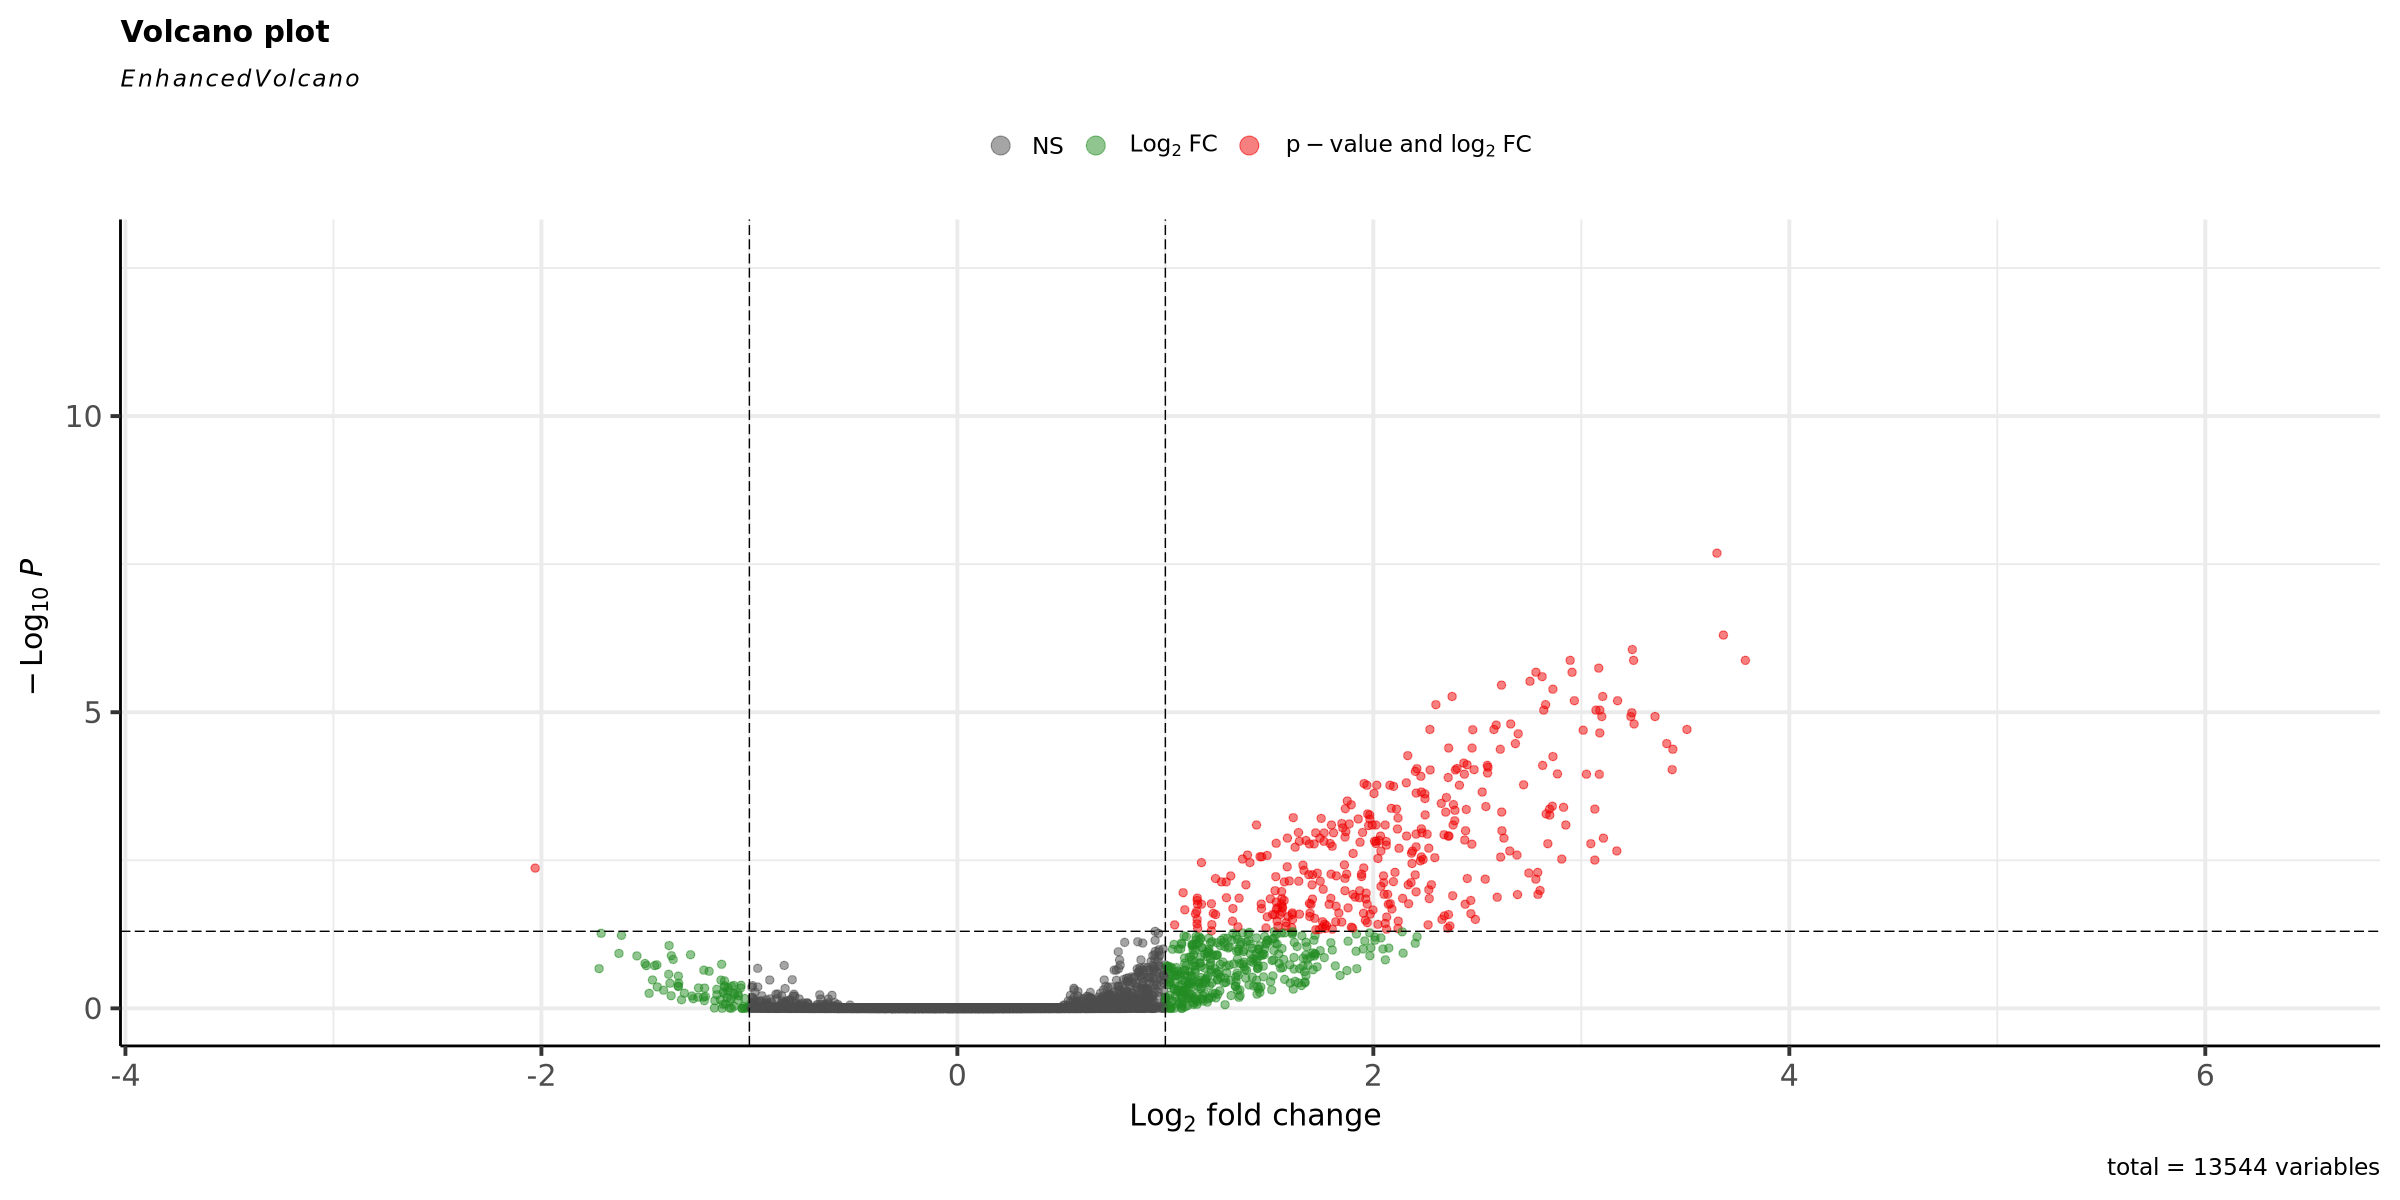

In [59]:
contrast1 <- c("Phase1", "warm", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p1wc<-lfcShrink(p1_dds, # dds object
                      contrast = contrast1, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1wc)

EnhancedVolcano(ls_p1wc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [60]:
# saving data into a csv file to look at kegg enrichment
write.csv(ls_p1wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_sig_genes/p1wc_lfc25_genes.csv')

In [12]:
# creating df of DESeq result
p1wc_shrink <- as.data.frame(ls_p1wc)

# adding column to denote that these are for warm vs. control samples
p1wc_shrink$plot <- 'warm_vs_control'

# adding column to tell us if this gene has more methylation in warming or control
p1wc_shrink$more_me_in <- ifelse(p1wc_shrink$log2FoldChange<0 & p1wc_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1wc_shrink$log2FoldChange>0 & p1wc_shrink$padj < 0.05, "warm", # pos ES = pathway for warm
                               "not significant"))

head(p1wc_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,plot,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.9171026,0.5117345,0.7219483,0.3625391,0.71694919,NA,warm_vs_control,NA
LOC111109452,1.3692365,1.0072548,0.7205748,1.0509038,0.29330277,NA,warm_vs_control,NA
LOC111124802,160.7331187,0.4591660,0.1879969,1.1126035,0.26587874,1.0000000,warm_vs_control,not significant
LOC111101273,55.0404755,0.4055670,0.2258263,0.6888791,0.49089935,1.0000000,warm_vs_control,not significant
LOC111101250,77.7947775,-0.6027753,0.2031945,-1.7361458,0.08253806,0.6036878,warm_vs_control,not significant
LOC111101262,188.9039051,0.1674635,0.1795188,0.0000000,1.00000000,1.0000000,warm_vs_control,not significant


repeating above, but looking at **Phase 1 hypoxic vs. control**

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13538 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 601, 4.4%
low counts [2]     : 6, 0.044%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



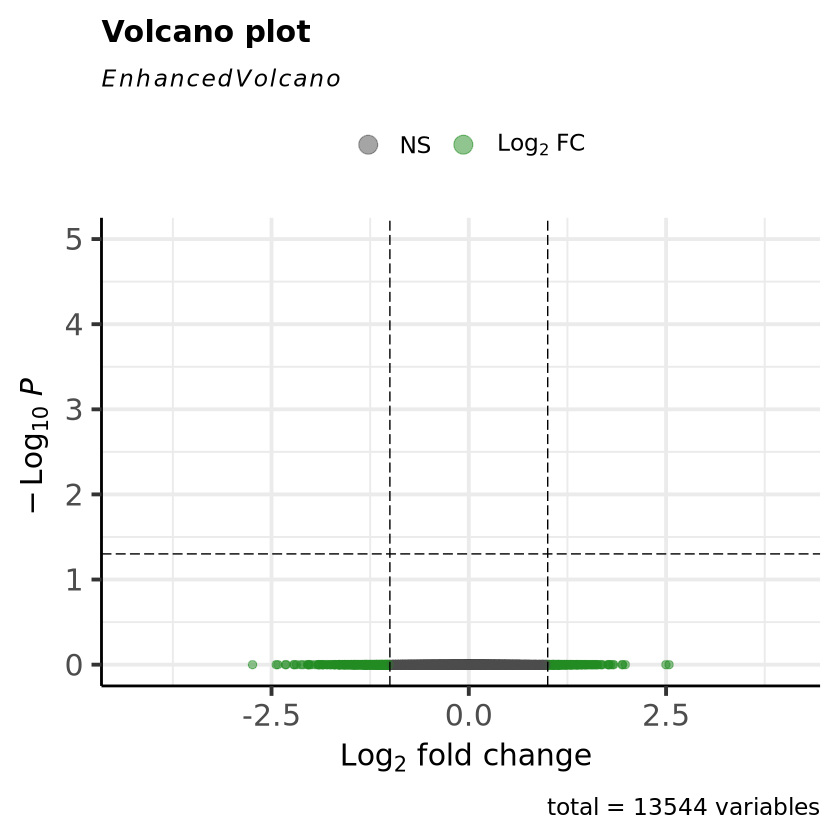

In [13]:
contrast2 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p1hc<-lfcShrink(p1_dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1hc)

EnhancedVolcano(ls_p1hc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [14]:
# creating df of DESeq result
p1hc_shrink <- as.data.frame(ls_p1hc)

# adding column to denote that these are for hypoxic vs. control samples
p1hc_shrink$plot <- 'hypoxic_vs_control'

# adding column to tell us if this gene has more methylation in hypoxia or control
p1hc_shrink$more_me_in <- ifelse(p1hc_shrink$log2FoldChange<0 & p1hc_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1hc_shrink$log2FoldChange>0 & p1hc_shrink$padj < 0.05, "hypoxia", # pos ES = pathway for warm
                               "not significant"))

head(p1hc_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,plot,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.9171026,-0.47211850,0.7009473,-0.3168833,0.7513321,1,hypoxic_vs_control,not significant
LOC111109452,1.3692365,0.45155837,0.7241066,0.2783545,0.7807402,1,hypoxic_vs_control,not significant
LOC111124802,160.7331187,0.01015871,0.1456254,0.0000000,1.0000000,1,hypoxic_vs_control,not significant
LOC111101273,55.0404755,-0.12778328,0.1709562,0.0000000,1.0000000,1,hypoxic_vs_control,not significant
LOC111101250,77.7947775,-0.20645216,0.1441565,0.0000000,1.0000000,1,hypoxic_vs_control,not significant
LOC111101262,188.9039051,0.01284188,0.1377824,0.0000000,1.0000000,1,hypoxic_vs_control,not significant


now adding the two data frames together

In [15]:
phase1 <- rbind(p1wc_shrink, p1hc_shrink)
phase1<- na.omit(phase1)
tail(phase1)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,plot,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC1111169411,9.4281985,1.2951418,0.6177018,1.6919845,0.09064893,1,hypoxic_vs_control,not significant
LOC1111175661,2.0103277,0.4575072,0.4862327,0.4267652,0.66955039,1,hypoxic_vs_control,not significant
LOC1111176891,20.3169059,-0.2189097,0.2553920,0.0000000,1.00000000,1,hypoxic_vs_control,not significant
LOC1111171201,0.9885273,-0.4105955,0.6906943,-0.2325131,0.81613949,1,hypoxic_vs_control,not significant
LOC1111171151,0.3123175,-0.5419666,0.7202081,-0.4053920,0.68518943,1,hypoxic_vs_control,not significant
LOC1111166031,0.9944027,-0.1856000,0.6687666,0.0000000,1.00000000,1,hypoxic_vs_control,not significant


### ggplot2 of DESeq data

now looking at ggplot but faceting by plot

looking at phase 1 warm vs. control and hypoxia vs. control

question - do we need to shrink for volcano plot? or do we only need to shrink for 

In [16]:
# changes size of plots
options(repr.plot.width=20, repr.plot.height=10)

In [17]:
# Allows me to change the name of the facet grid
grid_names <- c(`hypoxic_vs_control` = "Hypoxia vs. Control",
                    `warm_vs_control` = "Warm vs. Control")

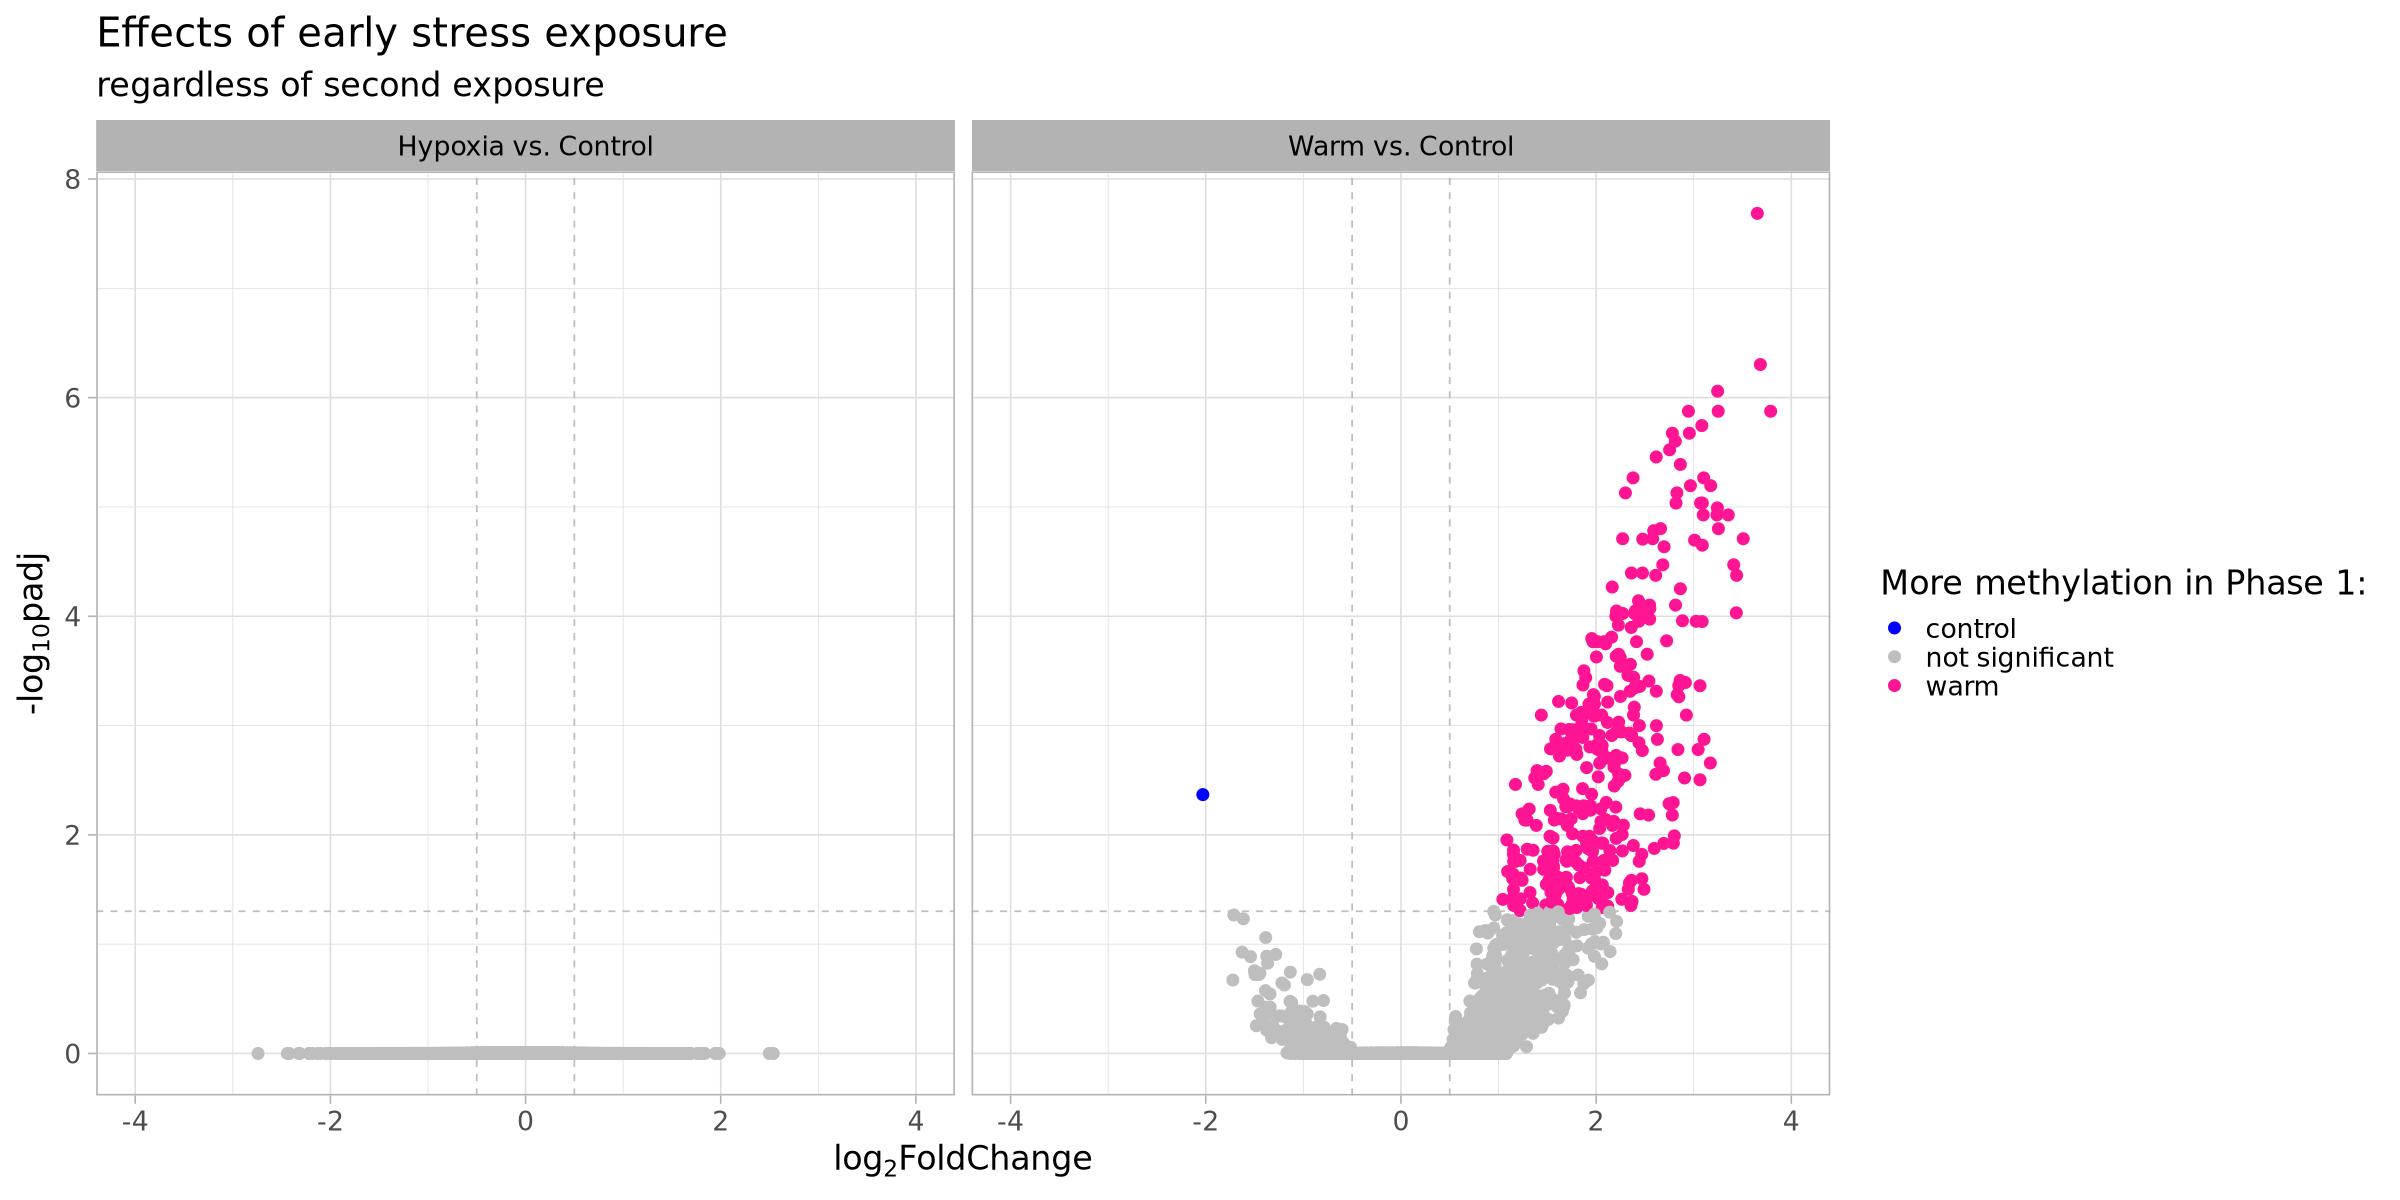

In [18]:
volcano_plot_p1 <- ggplot(data = phase1, aes(x = log2FoldChange, y = -log10(padj), col = more_me_in)) +
geom_vline(xintercept = c(-0.5,0.5), col = "gray", linetype = 'dashed') + # fold change threshold line
facet_grid(~plot, labeller = as_labeller(grid_names)) +
geom_hline(yintercept = -log10(0.05), col = "gray", linetype = 'dashed') + # padj threshold line
geom_point(size=3) +
scale_color_manual(values = c('blue','gray','deeppink', 'purple')) + 
theme_light(base_size=20) + 
theme(strip.text = element_text(color='black')) + 
labs(title = 'Effects of early stress exposure', subtitle = 'regardless of second exposure',
     col='More methylation in Phase 1:', x = expression("log"[2]*"FoldChange"), y = expression("-log"[10]*"padj")) +
scale_x_continuous(limits = c(-4,4))

volcano_plot_p1

In [19]:
# saving plot as pdf file

# open pdf file
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures')
pdf('volcano_p1wc_hc.pdf', width=20, height=10)

# open plot
volcano_plot_p1

# close pdf file
dev.off()

png 
  2

now doing the same thing for CE of hypoxia

### **Effects of Phase 2, Given Phase 1**
in other words - looking at:
- phase 1 = control, phase 2 = hypoxia or control
- phase 2 = hypoxia, phase 2 = hypoxia or control

starting with **phase 1 = *control*** first

In [20]:
# first need to filter for samples that were control for phase 1
p1_control <- filter(meta, meta$Phase1 == 'control')
head(p1_control)

# now select those same samples out of the counts matrix
p1c_counts <- counts2[,colnames(counts2) %in% rownames(p1_control)]
head(p1c_counts)

,Phase1,Phase2
,<chr>,<chr>
WBB-WBV-W69,control,control
WBG-BBB-W56,control,hypoxic
WBG-WBG-W44,control,control
WBO-BBR-W03,control,hypoxic
WBO-WBV-W64,control,control
WBR-BBY-W25,control,hypoxic


,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,3,1,0,0,1,0,0,0,0,1
LOC111109452,0,1,0,0,7,0,1,0,1,2
LOC111124802,418,455,76,20,305,122,120,57,289,202
LOC111101273,132,127,49,8,143,43,45,18,87,81
LOC111101250,212,261,56,7,201,91,96,24,254,109
LOC111101262,453,485,102,40,422,184,146,52,387,251


both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [21]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1c_dds <- DESeqDataSetFromMatrix(countData = p1c_counts,
                              colData = p1_control, 
                              design = ~ Phase2)
p1c_dds=DESeq(p1c_dds)
resultsNames(p1c_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase2_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13274 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 1, 0.0075%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 175, 1.3%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



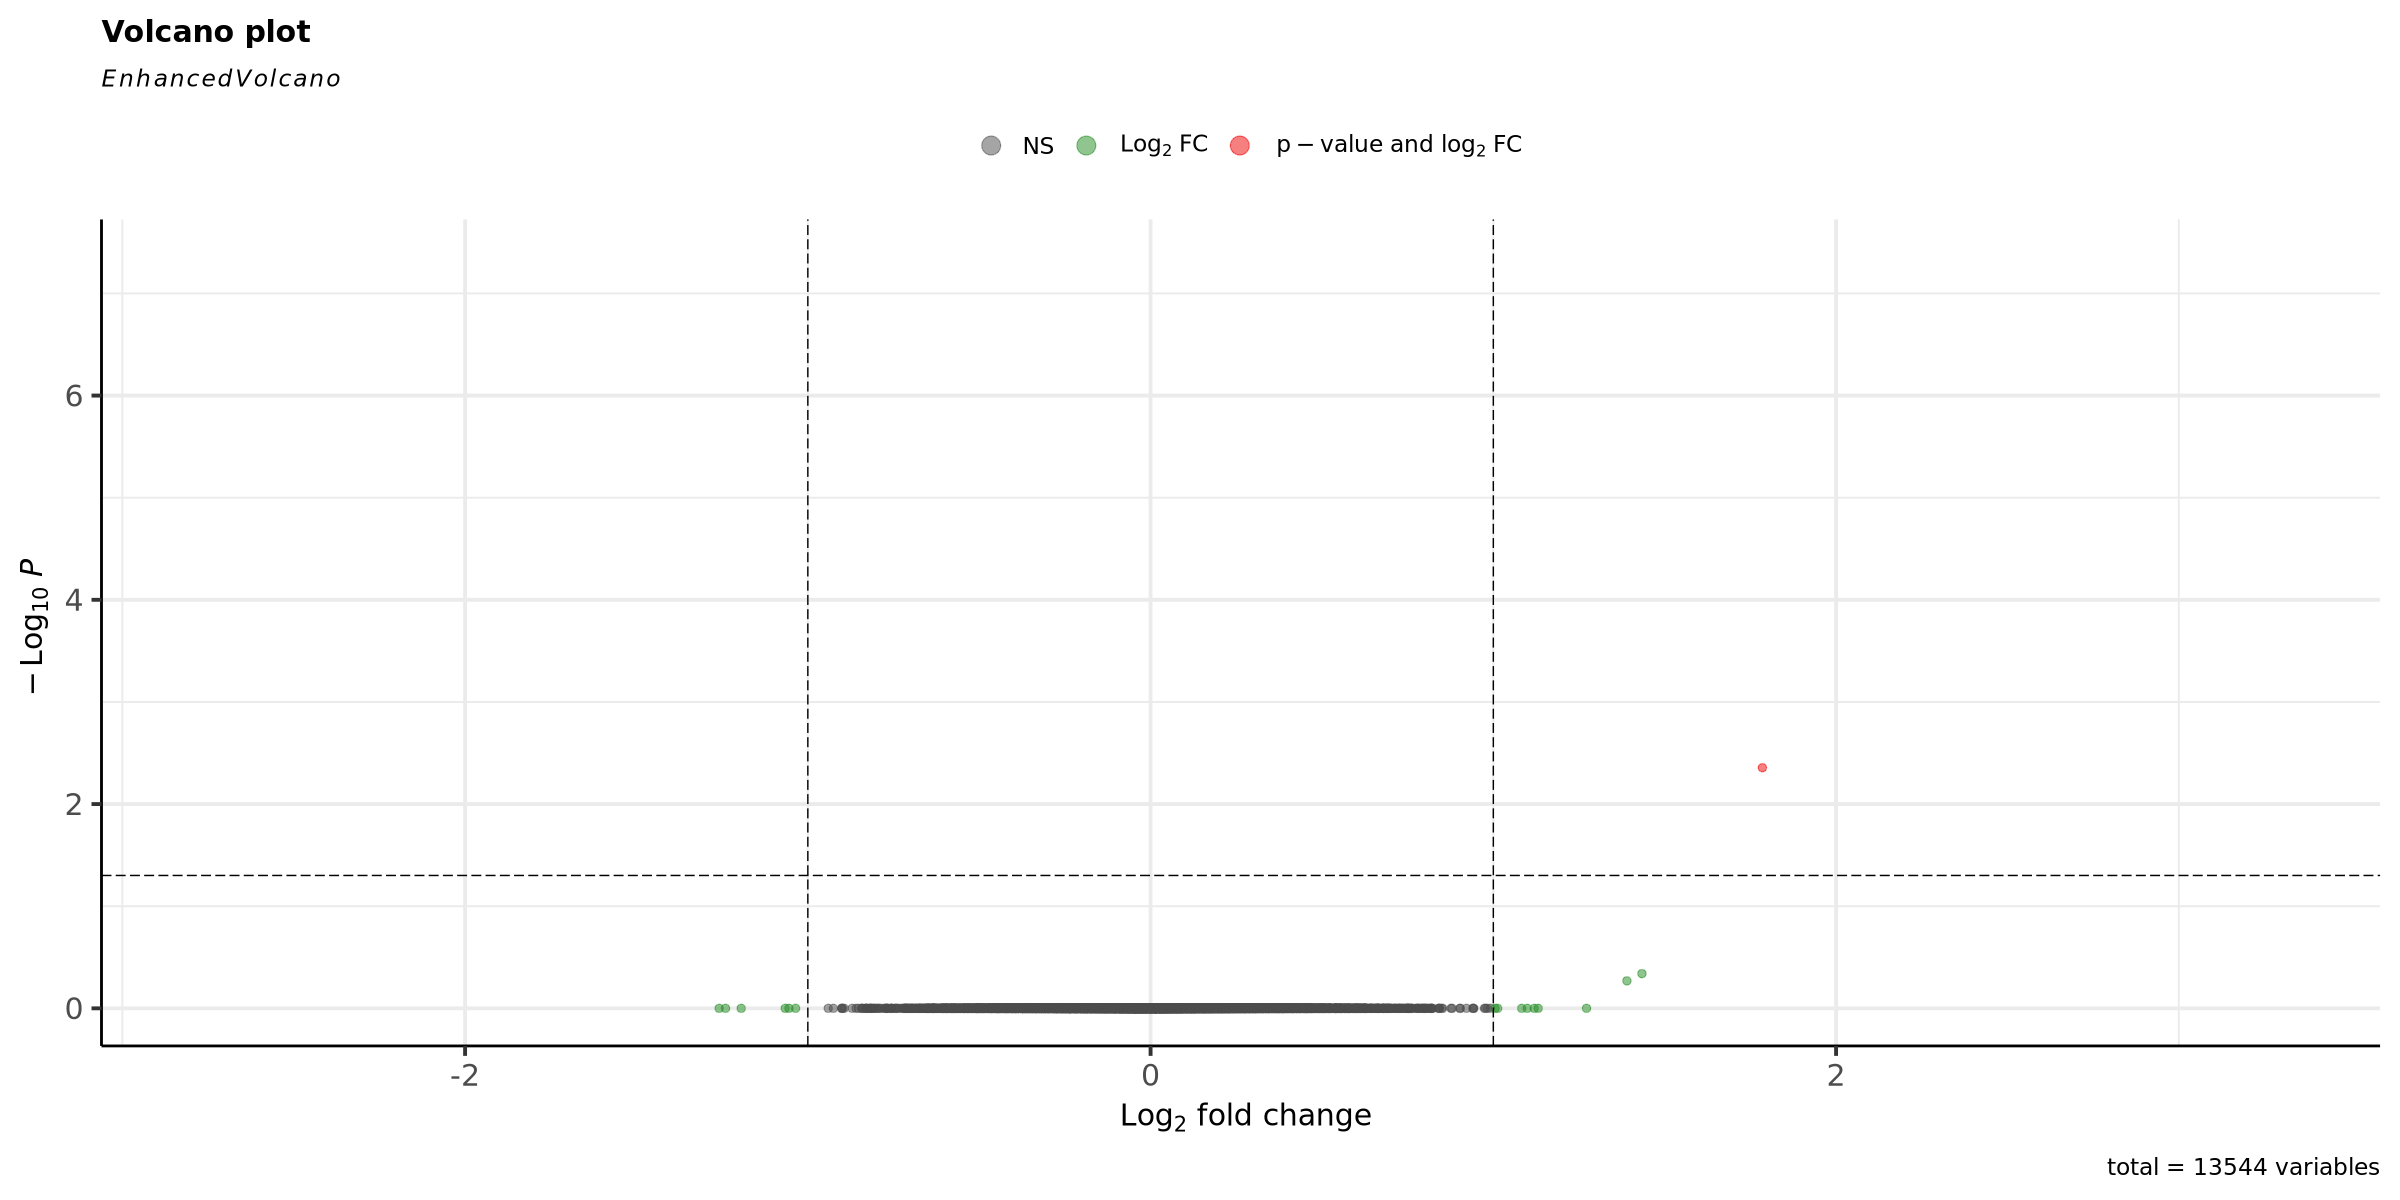

In [22]:
contrast2 <- c("Phase2", "hypoxic", "control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p1c<-lfcShrink(p1c_dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1c)

EnhancedVolcano(ls_p1c, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [23]:
# creating df of DESeq result
p1c_shrink <- as.data.frame(ls_p1c)

# adding column to denote that these are for warm vs. control samples
p1c_shrink$phase1 <- 'control'

# adding column to tell us if this gene has more methylation in warming or control
p1c_shrink$more_me_in <- ifelse(p1c_shrink$log2FoldChange<0 & p1c_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1c_shrink$log2FoldChange>0 & p1c_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p1c_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase1,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.2502286,-0.01831450,0.1324564,0.00000000,1.0000000,1,control,not significant
LOC111109452,0.6276346,-0.06431818,0.1758236,0.00000000,1.0000000,1,control,not significant
LOC111124802,143.4993752,0.01425287,0.1425472,0.00000000,1.0000000,1,control,not significant
LOC111101273,54.3974633,-0.25915086,0.1971998,-0.04640401,0.9629882,1,control,not significant
LOC111101250,88.6108831,0.06661223,0.1889832,0.00000000,1.0000000,1,control,not significant
LOC111101262,182.2669054,0.15981376,0.1181916,0.00000000,1.0000000,1,control,not significant


now doing the same thing but for **phase 1 = *hypoxic***

In [24]:
# first need to filter for samples that were control for phase 1
p1_hypoxia <- filter(meta, meta$Phase1 == 'hypoxic')
head(p1_hypoxia)

# now select those same samples out of the counts matrix
p1h_counts <- counts2[,colnames(counts2) %in% rownames(p1_hypoxia)]
head(p1h_counts)

,Phase1,Phase2
,<chr>,<chr>
BBB-WBO-B21,hypoxic,control
BBB-WBV-B70,hypoxic,control
BBO-BBO-B16,hypoxic,hypoxic
BBO-BBY-B27,hypoxic,hypoxic
BBO-WBO-B16,hypoxic,control
BBO-WBV-B64,hypoxic,control


,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,2,2,0,0,2,0,0,0,1,0
LOC111109452,0,0,0,0,1,1,10,12,0,2
LOC111124802,597,453,408,244,502,434,187,336,311,110
LOC111101273,173,146,115,75,171,158,64,115,137,45
LOC111101250,253,255,257,118,327,269,115,141,184,49
LOC111101262,645,634,502,364,647,677,246,389,355,108


both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [25]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1h_dds <- DESeqDataSetFromMatrix(countData = p1h_counts,
                              colData = p1_hypoxia, 
                              design = ~ Phase2)
p1h_dds=DESeq(p1h_dds)
resultsNames(p1h_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase2_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13397 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 258, 1.9%
LFC < -0.25 (down) : 87, 0.65%
outliers [1]       : 302, 2.3%
low counts [2]     : 3570, 27%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



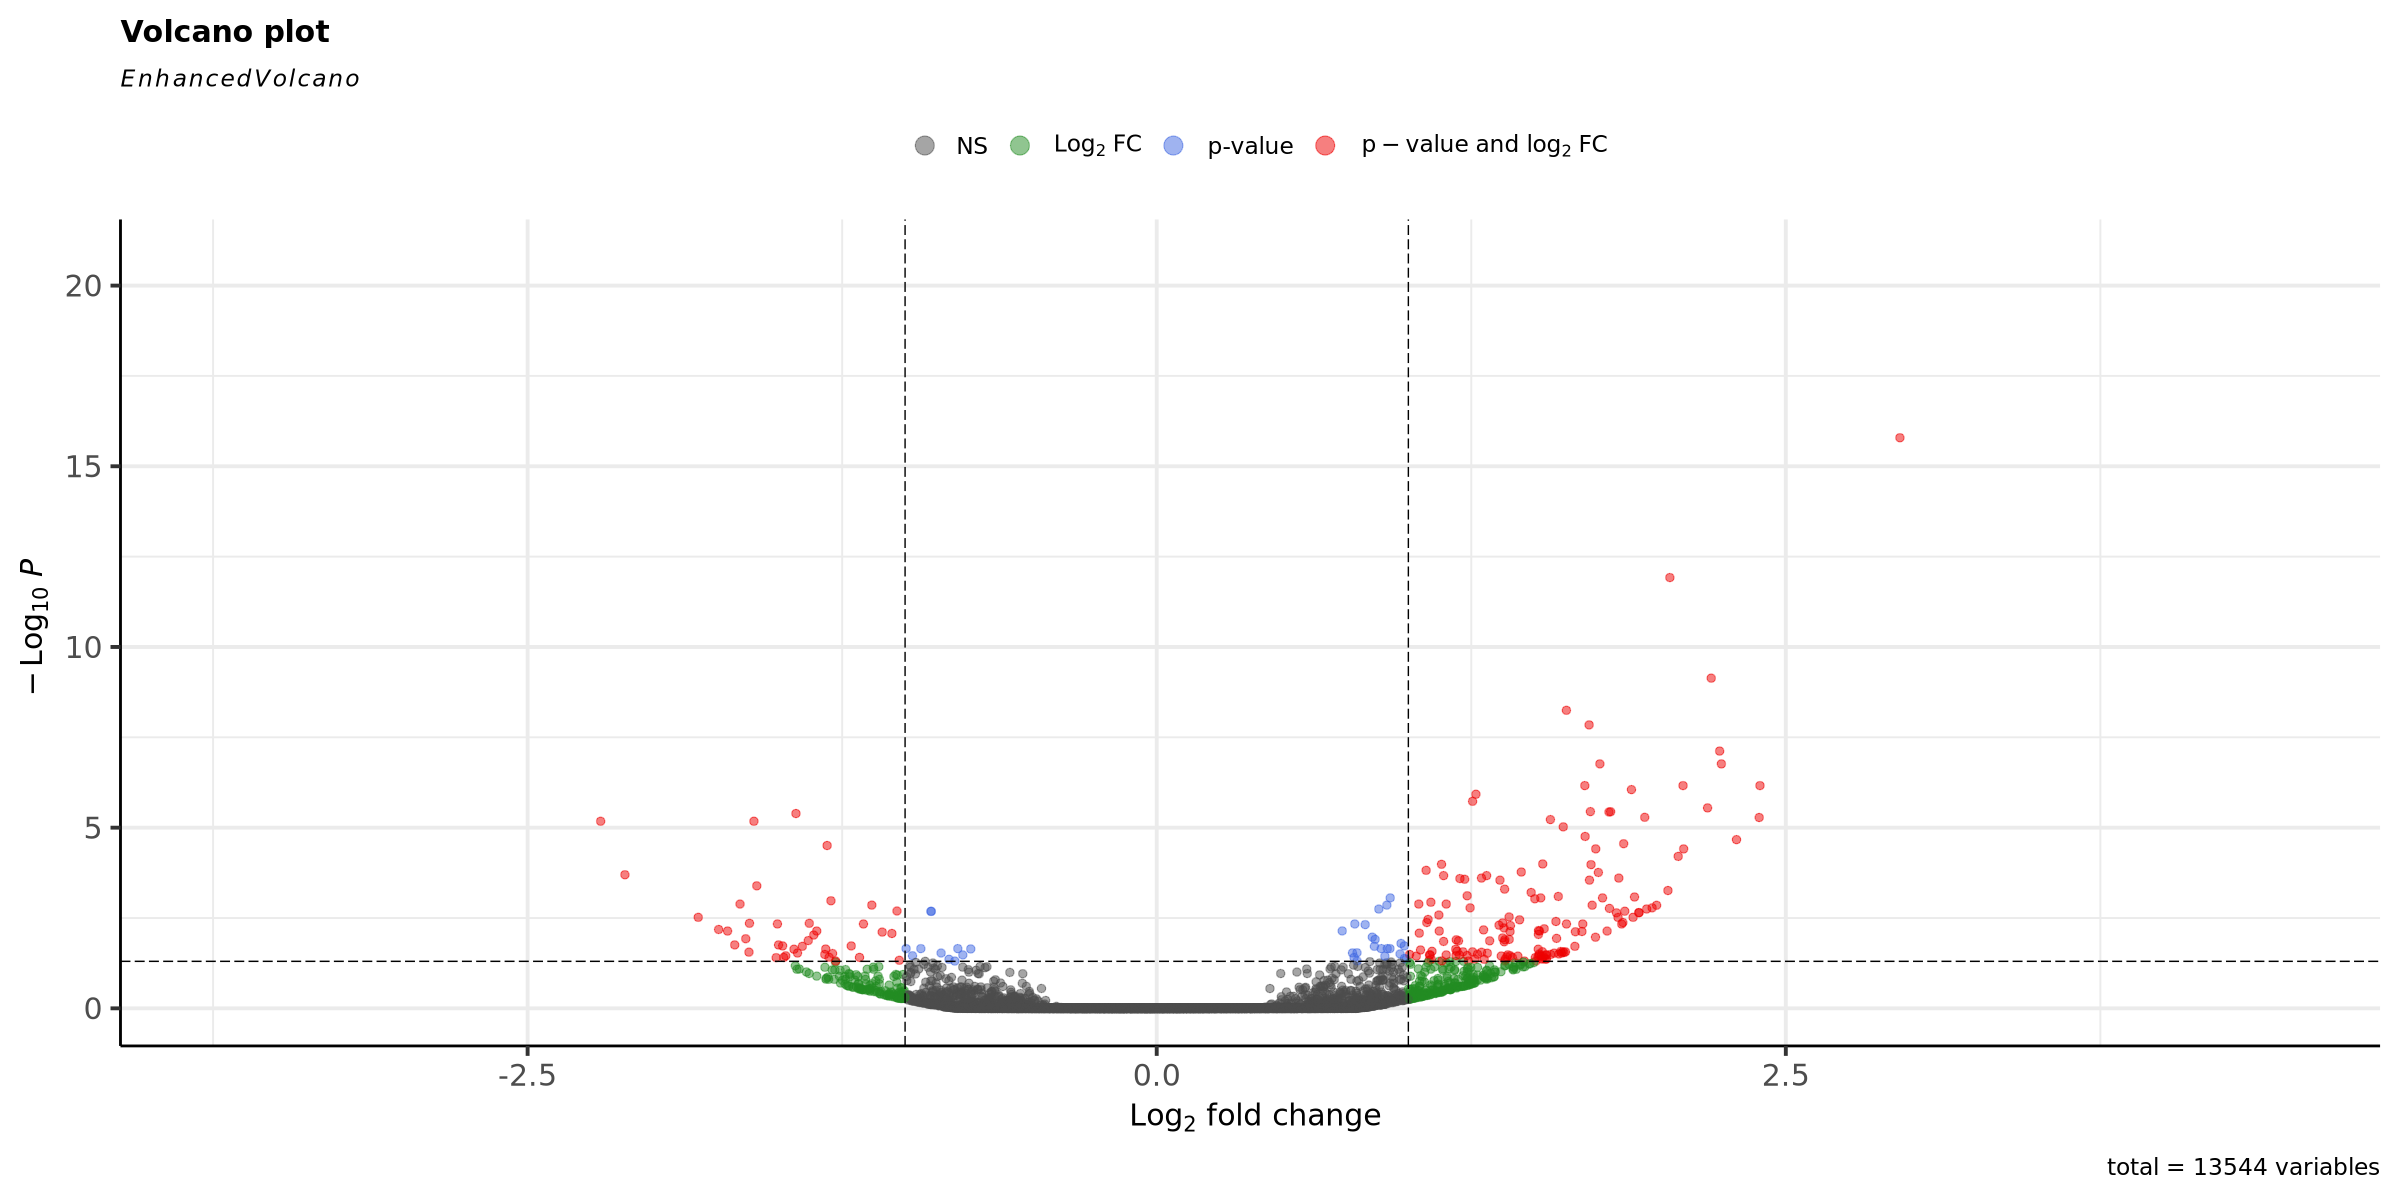

In [26]:
contrast3 <- c("Phase2", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p1h<-lfcShrink(p1h_dds, # dds object
                      contrast = contrast3, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1h)

EnhancedVolcano(ls_p1h, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [27]:
# creating df of DESeq result
p1h_shrink <- as.data.frame(ls_p1h)

# adding column to denote that these are for warm vs. control samples
p1h_shrink$phase1 <- 'hypoxic'

# adding column to tell us if this gene has more methylation in warming or control
p1h_shrink$more_me_in <- ifelse(p1h_shrink$log2FoldChange<0 & p1h_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1h_shrink$log2FoldChange>0 & p1h_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p1h_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase1,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.4784028,-0.23790209,0.2750150,0.0000000,1.000000,NA,hypoxic,NA
LOC111109452,3.3386872,0.31180570,0.2956137,0.2090759,0.834389,1,hypoxic,not significant
LOC111124802,316.6081421,-0.07839417,0.1033729,0.0000000,1.000000,1,hypoxic,not significant
LOC111101273,107.9962355,-0.05650996,0.1242150,0.0000000,1.000000,1,hypoxic,not significant
LOC111101250,171.6397521,-0.04906065,0.1585186,0.0000000,1.000000,1,hypoxic,not significant
LOC111101262,399.0652461,-0.07049632,0.1311921,0.0000000,1.000000,1,hypoxic,not significant


now combining the two dataframes into one

In [28]:
ce_df <- rbind(p1c_shrink, p1h_shrink)
ce_df <- na.omit(ce_df)
head(ce_df)
tail(ce_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase1,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.2502286,-0.01831450,0.1324564,0.00000000,1.0000000,1,control,not significant
LOC111109452,0.6276346,-0.06431818,0.1758236,0.00000000,1.0000000,1,control,not significant
LOC111124802,143.4993752,0.01425287,0.1425472,0.00000000,1.0000000,1,control,not significant
LOC111101273,54.3974633,-0.25915086,0.1971998,-0.04640401,0.9629882,1,control,not significant
LOC111101250,88.6108831,0.06661223,0.1889832,0.00000000,1.0000000,1,control,not significant
LOC111101262,182.2669054,0.15981376,0.1181916,0.00000000,1.0000000,1,control,not significant


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase1,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC1111169711,147.325478,-0.3748286,0.1574935,-0.7925956,0.42801350,1.0000000,hypoxic,not significant
LOC1111165951,3.246669,-0.1488773,0.2882214,0.0000000,1.00000000,1.0000000,hypoxic,not significant
LOC1111169411,33.832417,-1.1522612,0.3898890,-2.3141488,0.02065956,0.3173908,hypoxic,not significant
LOC1111175661,6.679199,-0.7714915,0.3770011,-1.3832625,0.16658439,1.0000000,hypoxic,not significant
LOC1111176891,46.611130,0.4271551,0.2538148,0.6979701,0.48519592,1.0000000,hypoxic,not significant
LOC1111171201,2.733355,0.6498042,0.3427223,1.1665542,0.24339044,1.0000000,hypoxic,not significant


### Effects of phase one, given phase 2
looking at samples that are:
- phase 1 = hypoxic or control, phase 2 = hypoxic
- phase 1 = hypoxic or control, phase 2 = control

starting with **phase 2 = control**

In [29]:
# first need to filter for samples that were control for phase 1
p2_control <- filter(meta, meta$Phase2 == 'control')
head(p2_control)

# now select those same samples out of the counts matrix
p2c_counts <- counts2[,colnames(counts2) %in% rownames(p2_control)]
head(p2c_counts)

,Phase1,Phase2
,<chr>,<chr>
BBB-WBO-B21,hypoxic,control
BBB-WBV-B70,hypoxic,control
BBO-WBO-B16,hypoxic,control
BBO-WBV-B64,hypoxic,control
BBY-WBG-B42,hypoxic,control
WBB-WBV-W69,control,control


,BBB-WBO-B21,BBB-WBV-B70,BBO-WBO-B16,BBO-WBV-B64,BBY-WBG-B42,WBB-WBV-W69,WBG-WBG-W44,WBO-WBV-W64,WBV-WBO-W23,WBV-WBR-W12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,2,2,2,0,0,3,0,1,0,0
LOC111109452,0,0,1,1,2,0,0,7,1,0
LOC111124802,597,453,502,434,110,418,76,305,120,57
LOC111101273,173,146,171,158,45,132,49,143,45,18
LOC111101250,253,255,327,269,49,212,56,201,96,24
LOC111101262,645,634,647,677,108,453,102,422,146,52


both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [30]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2c_dds <- DESeqDataSetFromMatrix(countData = p2c_counts,
                              colData = p2_control, 
                              design = ~ Phase1)
p2c_dds=DESeq(p2c_dds)
resultsNames(p2c_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13322 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 10, 0.075%
LFC < -0.25 (down) : 19, 0.14%
outliers [1]       : 286, 2.1%
low counts [2]     : 4972, 37%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



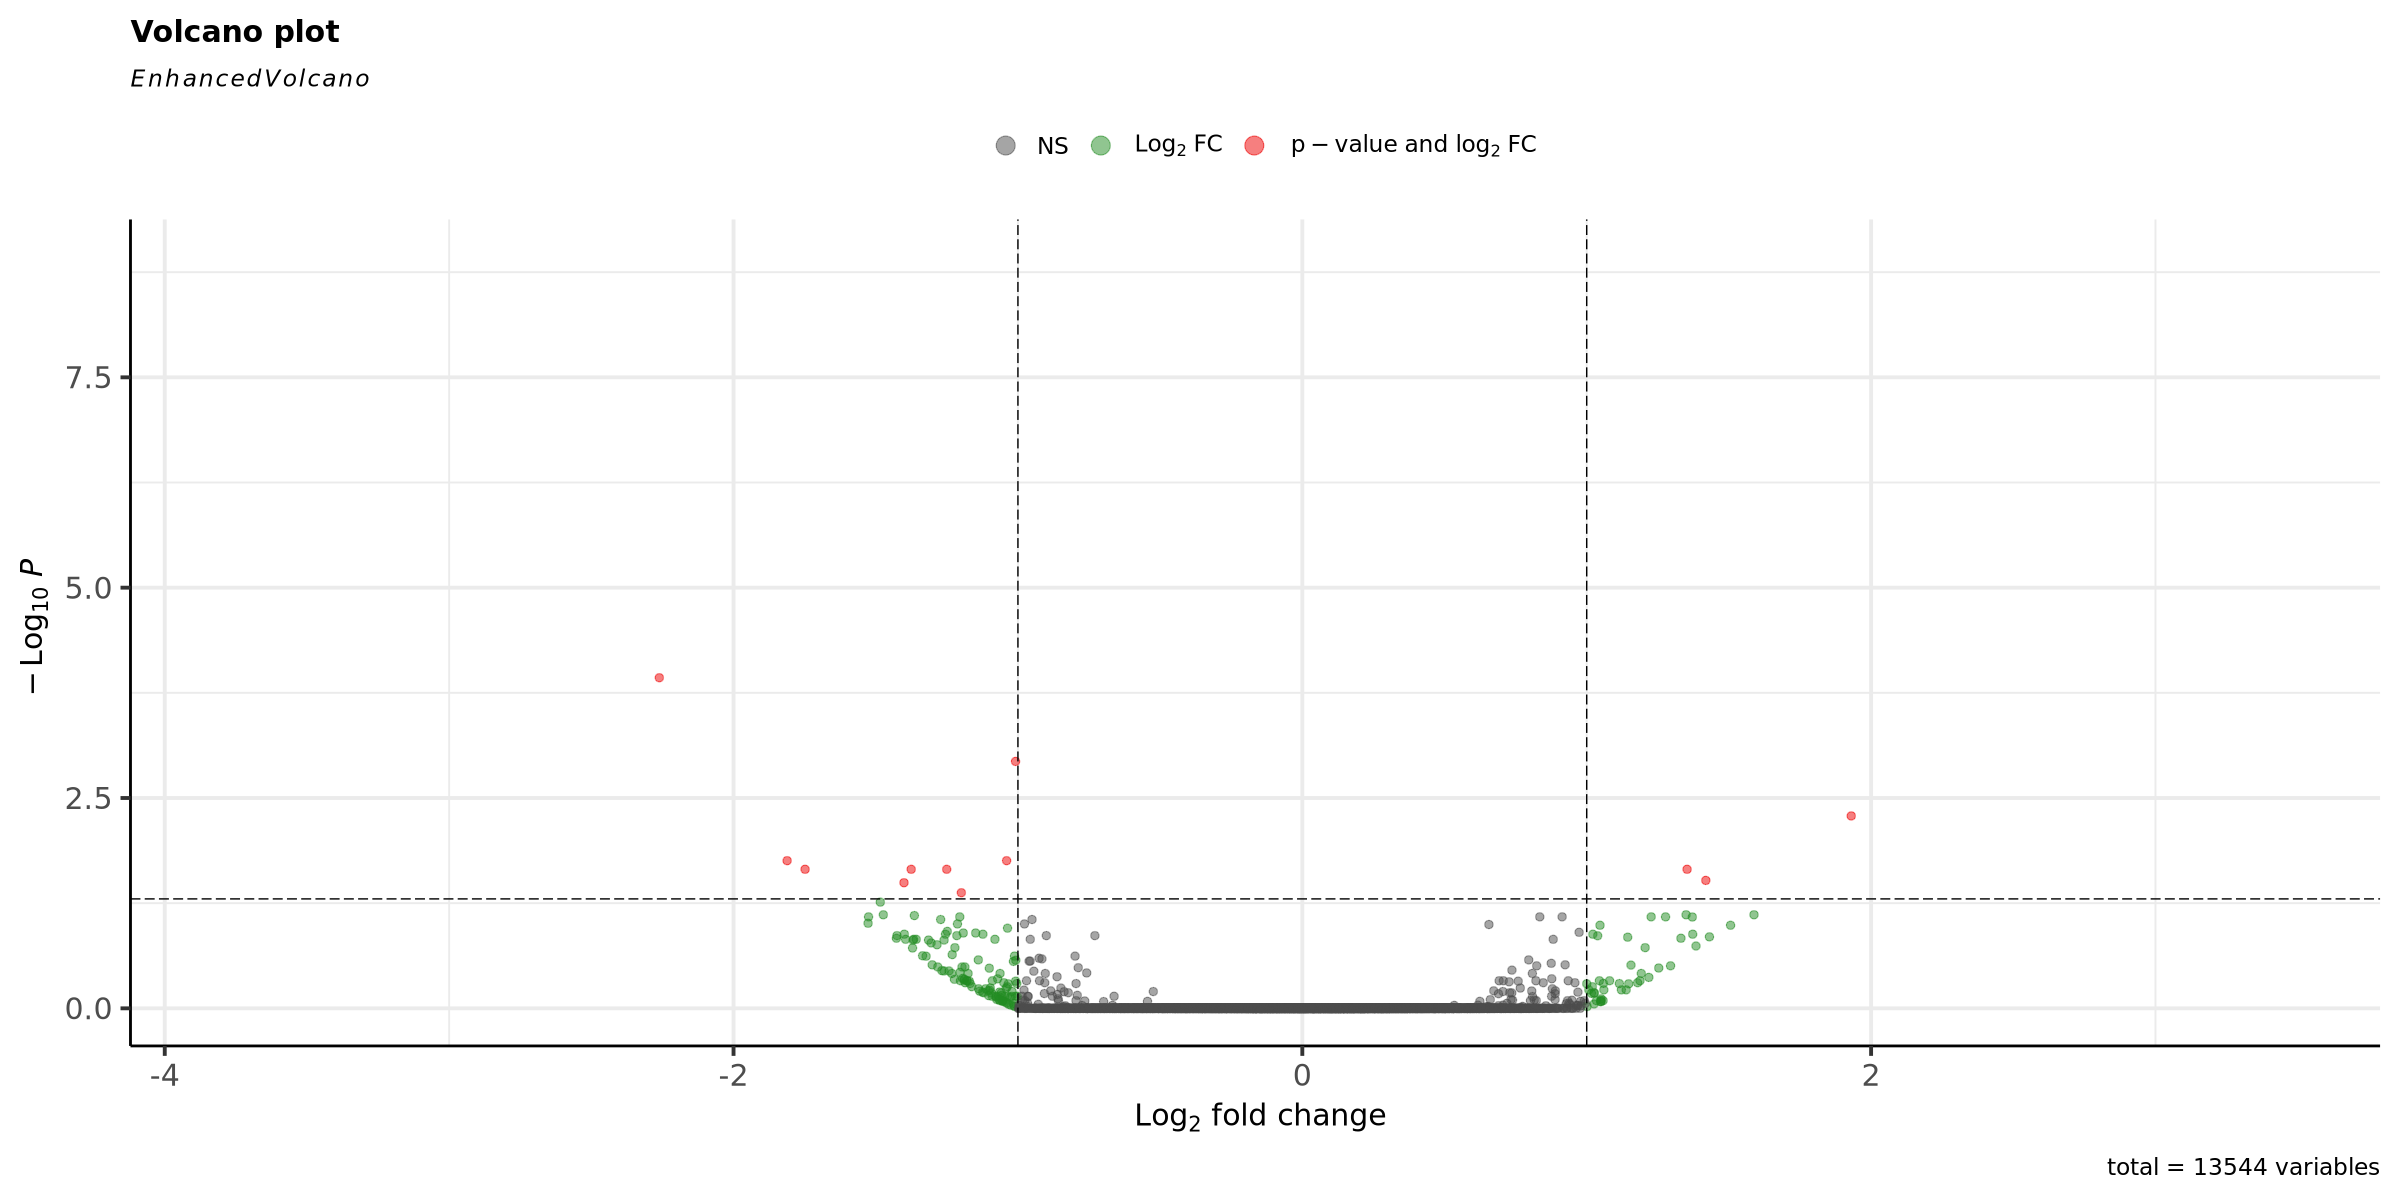

In [31]:
contrast2 <- c("Phase1", "hypoxic", "control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p2c<-lfcShrink(p2c_dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2c)

EnhancedVolcano(ls_p2c, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [32]:
# creating df of DESeq result
p2c_shrink <- as.data.frame(ls_p2c)

# adding column to denote that these are for warm vs. control samples
p2c_shrink$phase2 <- 'control'

# adding column to tell us if this gene has more methylation in warming or control
p2c_shrink$more_me_in <- ifelse(p2c_shrink$log2FoldChange<0 & p2c_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p2c_shrink$log2FoldChange>0 & p2c_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p2c_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase2,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.4910761,-0.04714912,0.2476821,0,1,NA,control,NA
LOC111109452,1.1290032,-0.11801920,0.2403346,0,1,NA,control,NA
LOC111124802,226.1235295,0.08476869,0.1166682,0,1,1,control,not significant
LOC111101273,85.7414499,-0.19260342,0.1756082,0,1,1,control,not significant
LOC111101250,128.8404578,-0.10155347,0.1388992,0,1,1,control,not significant
LOC111101262,272.8763882,0.16866172,0.1088131,0,1,1,control,not significant


now doing the same thing but for **phase 2 = *hypoxic***

In [33]:
# first need to filter for samples that were control for phase 1
p2_hypoxia <- filter(meta, meta$Phase2 == 'hypoxic')
head(p2_hypoxia)

# now select those same samples out of the counts matrix
p2h_counts <- counts2[,colnames(counts2) %in% rownames(p2_hypoxia)]
head(p2h_counts)

,Phase1,Phase2
,<chr>,<chr>
BBO-BBO-B16,hypoxic,hypoxic
BBO-BBY-B27,hypoxic,hypoxic
BBR-BBB-B50,hypoxic,hypoxic
BBR-BBG-B38,hypoxic,hypoxic
BBR-BBY-B26,hypoxic,hypoxic
WBG-BBB-W56,control,hypoxic


,BBO-BBO-B16,BBO-BBY-B27,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,WBG-BBB-W56,WBO-BBR-W03,WBR-BBY-W25,WBY-BBV-W65,WBY-BBY-W30
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,0,0,0,0,1,1,0,0,0,1
LOC111109452,0,0,10,12,0,1,0,0,1,2
LOC111124802,408,244,187,336,311,455,20,122,289,202
LOC111101273,115,75,64,115,137,127,8,43,87,81
LOC111101250,257,118,115,141,184,261,7,91,254,109
LOC111101262,502,364,246,389,355,485,40,184,387,251


both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [34]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2h_dds <- DESeqDataSetFromMatrix(countData = p2h_counts,
                              colData = p2_hypoxia, 
                              design = ~ Phase1)
p2h_dds=DESeq(p2h_dds)
resultsNames(p2h_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13371 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 190, 1.4%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



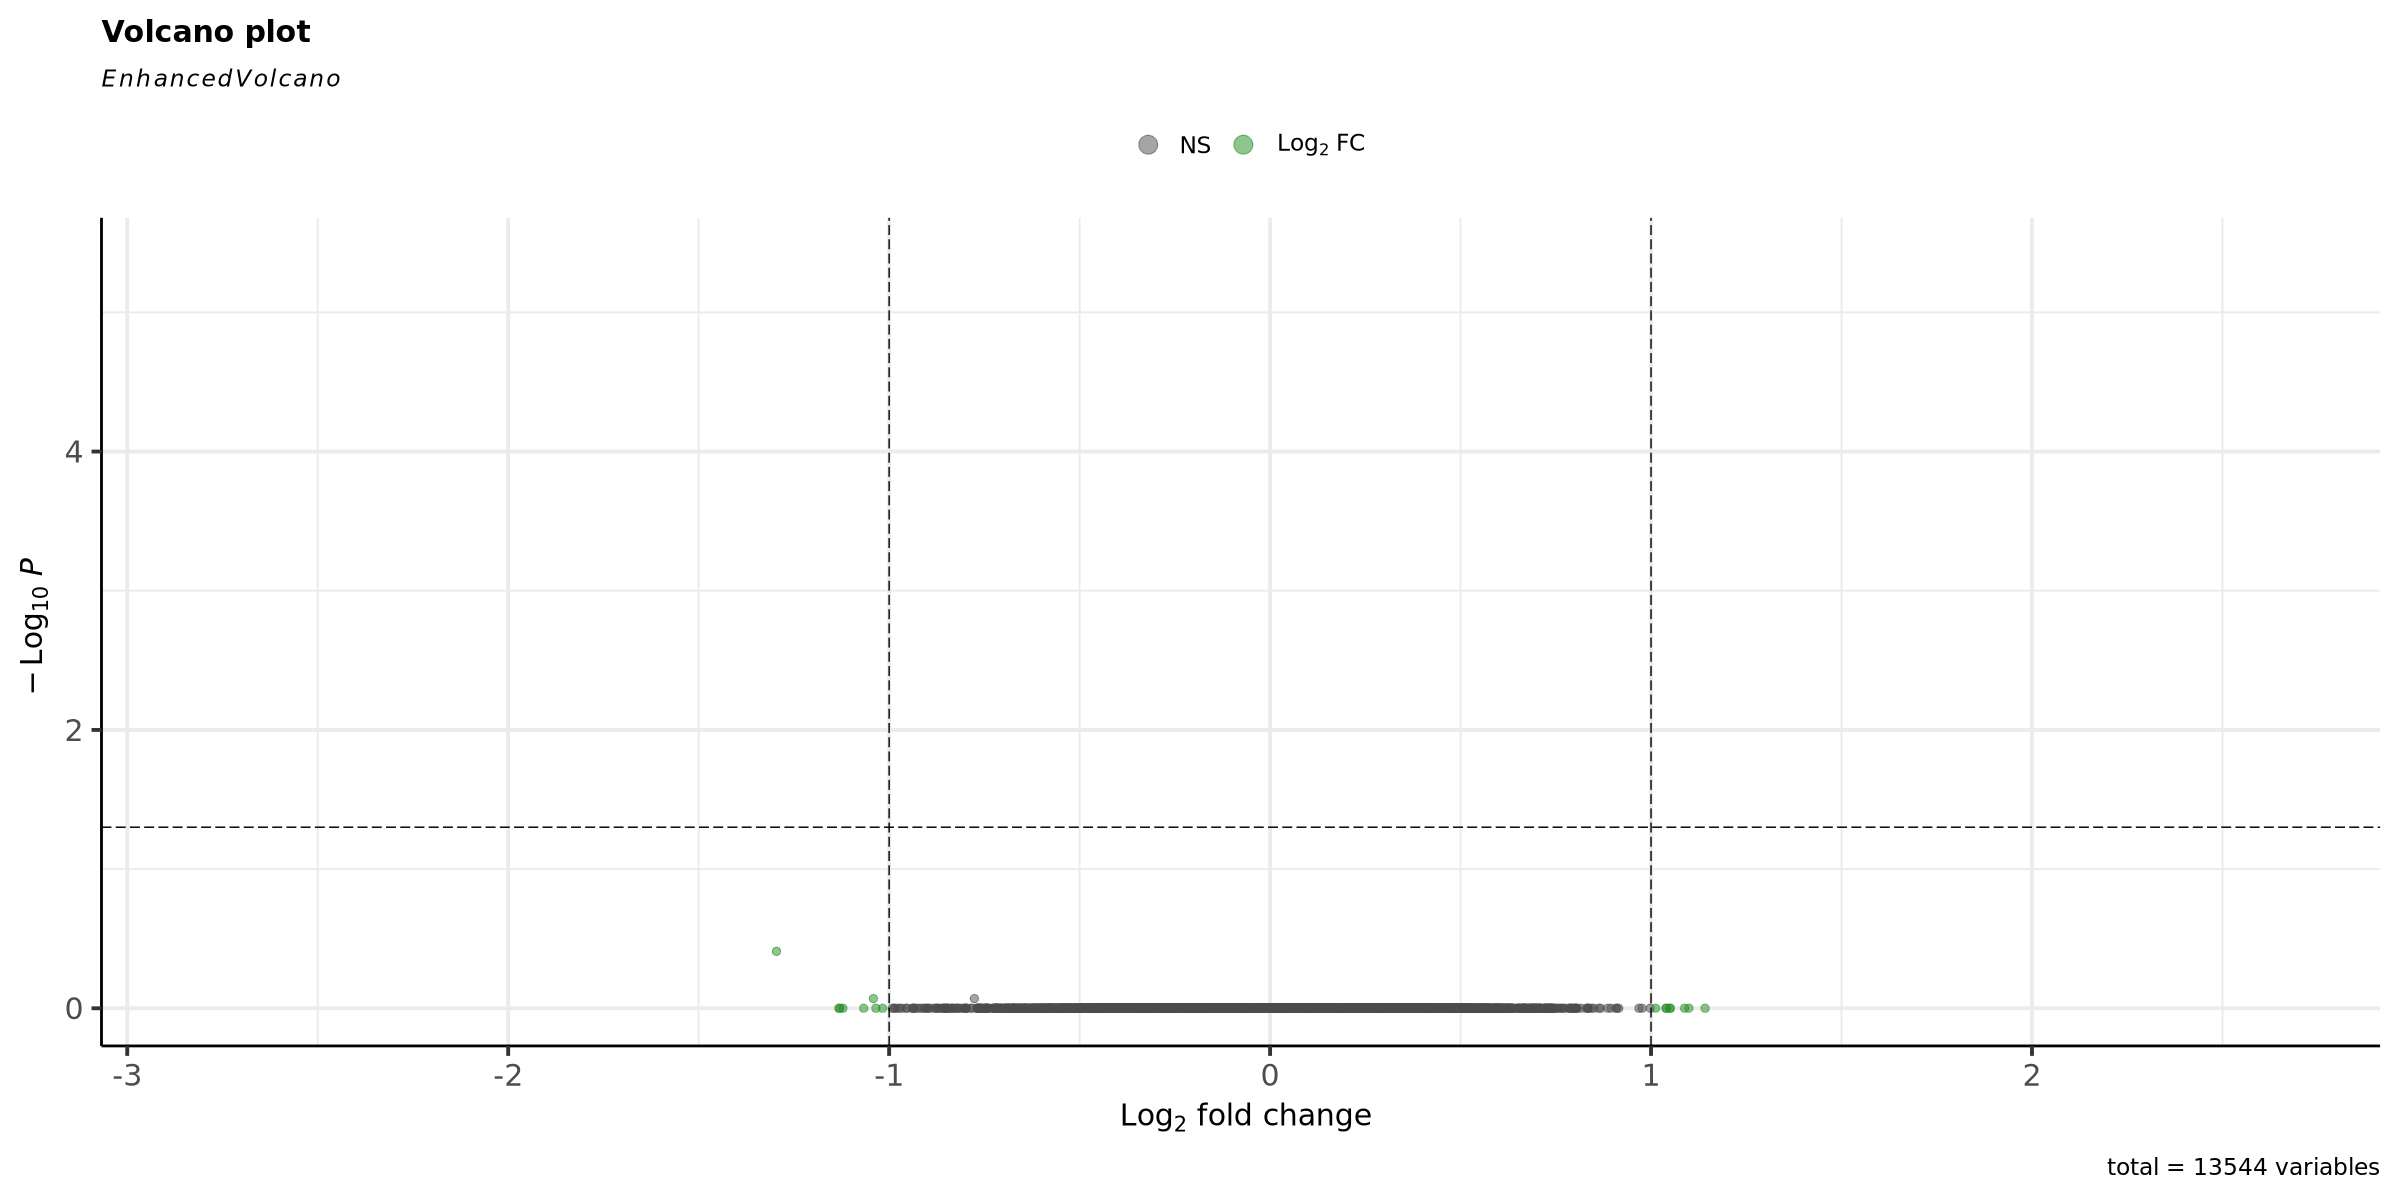

In [35]:
contrast3 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p2h<-lfcShrink(p2h_dds, # dds object
                      contrast = contrast3, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2h)

EnhancedVolcano(ls_p2h, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [36]:
# creating df of DESeq result
p2h_shrink <- as.data.frame(ls_p2h)

# adding column to denote that these are for warm vs. control samples
p2h_shrink$phase2 <- 'hypoxic'

# adding column to tell us if this gene has more methylation in warming or control
p2h_shrink$more_me_in <- ifelse(p2h_shrink$log2FoldChange<0 & p2h_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p2h_shrink$log2FoldChange>0 & p2h_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p2h_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase2,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.2131252,-0.05054711,0.1104550,0,1,1,hypoxic,not significant
LOC111109452,2.0357373,0.20682610,0.1948785,0,1,1,hypoxic,not significant
LOC111124802,201.1889314,-0.03983504,0.1260941,0,1,1,hypoxic,not significant
LOC111101273,68.3580053,-0.01221301,0.1537827,0,1,1,hypoxic,not significant
LOC111101250,118.8926870,-0.22774348,0.1976605,0,1,1,hypoxic,not significant
LOC111101262,266.8950865,-0.08979961,0.1326822,0,1,1,hypoxic,not significant


now combining the two dataframes into one

In [37]:
p2_ce_df <- rbind(p2c_shrink, p2h_shrink)
p2_ce_df <- na.omit(p2_ce_df)
head(p2_ce_df)
tail(p2_ce_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase2,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111124802,226.12353,0.08476869,0.1166682,0.0000000,1.000000e+00,1.00000000,control,not significant
LOC111101273,85.74145,-0.19260342,0.1756082,0.0000000,1.000000e+00,1.00000000,control,not significant
LOC111101250,128.84046,-0.10155347,0.1388992,0.0000000,1.000000e+00,1.00000000,control,not significant
LOC111101262,272.87639,0.16866172,0.1088131,0.0000000,1.000000e+00,1.00000000,control,not significant
LOC111133260,19.42014,-1.40066204,0.2815758,-4.0865094,4.379118e-05,0.03210292,control,control
LOC111113503,16.76014,0.36122234,0.3048477,0.3648456,7.152266e-01,1.00000000,control,not significant


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase2,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC1111169411,8.8195221,-0.0004124006,0.2814577,0,1,1,hypoxic,not significant
LOC1111175661,3.1299982,-0.1765113863,0.2909058,0,1,1,hypoxic,not significant
LOC1111176891,33.7798676,0.0168356950,0.2276975,0,1,1,hypoxic,not significant
LOC1111171201,3.0232900,-0.0249781247,0.2729776,0,1,1,hypoxic,not significant
LOC1111171151,0.2766184,-0.0411720456,0.1165609,0,1,1,hypoxic,not significant
LOC1111166031,0.9577939,0.1246599486,0.1742610,0,1,1,hypoxic,not significant


In [38]:
# changes size of plots
options(repr.plot.width=20, repr.plot.height=10)

In [39]:
# Allows me to change the name of the facet grid
grid_names <- c(`control` = "Control",
                    `hypoxic` = "Hypoxic")

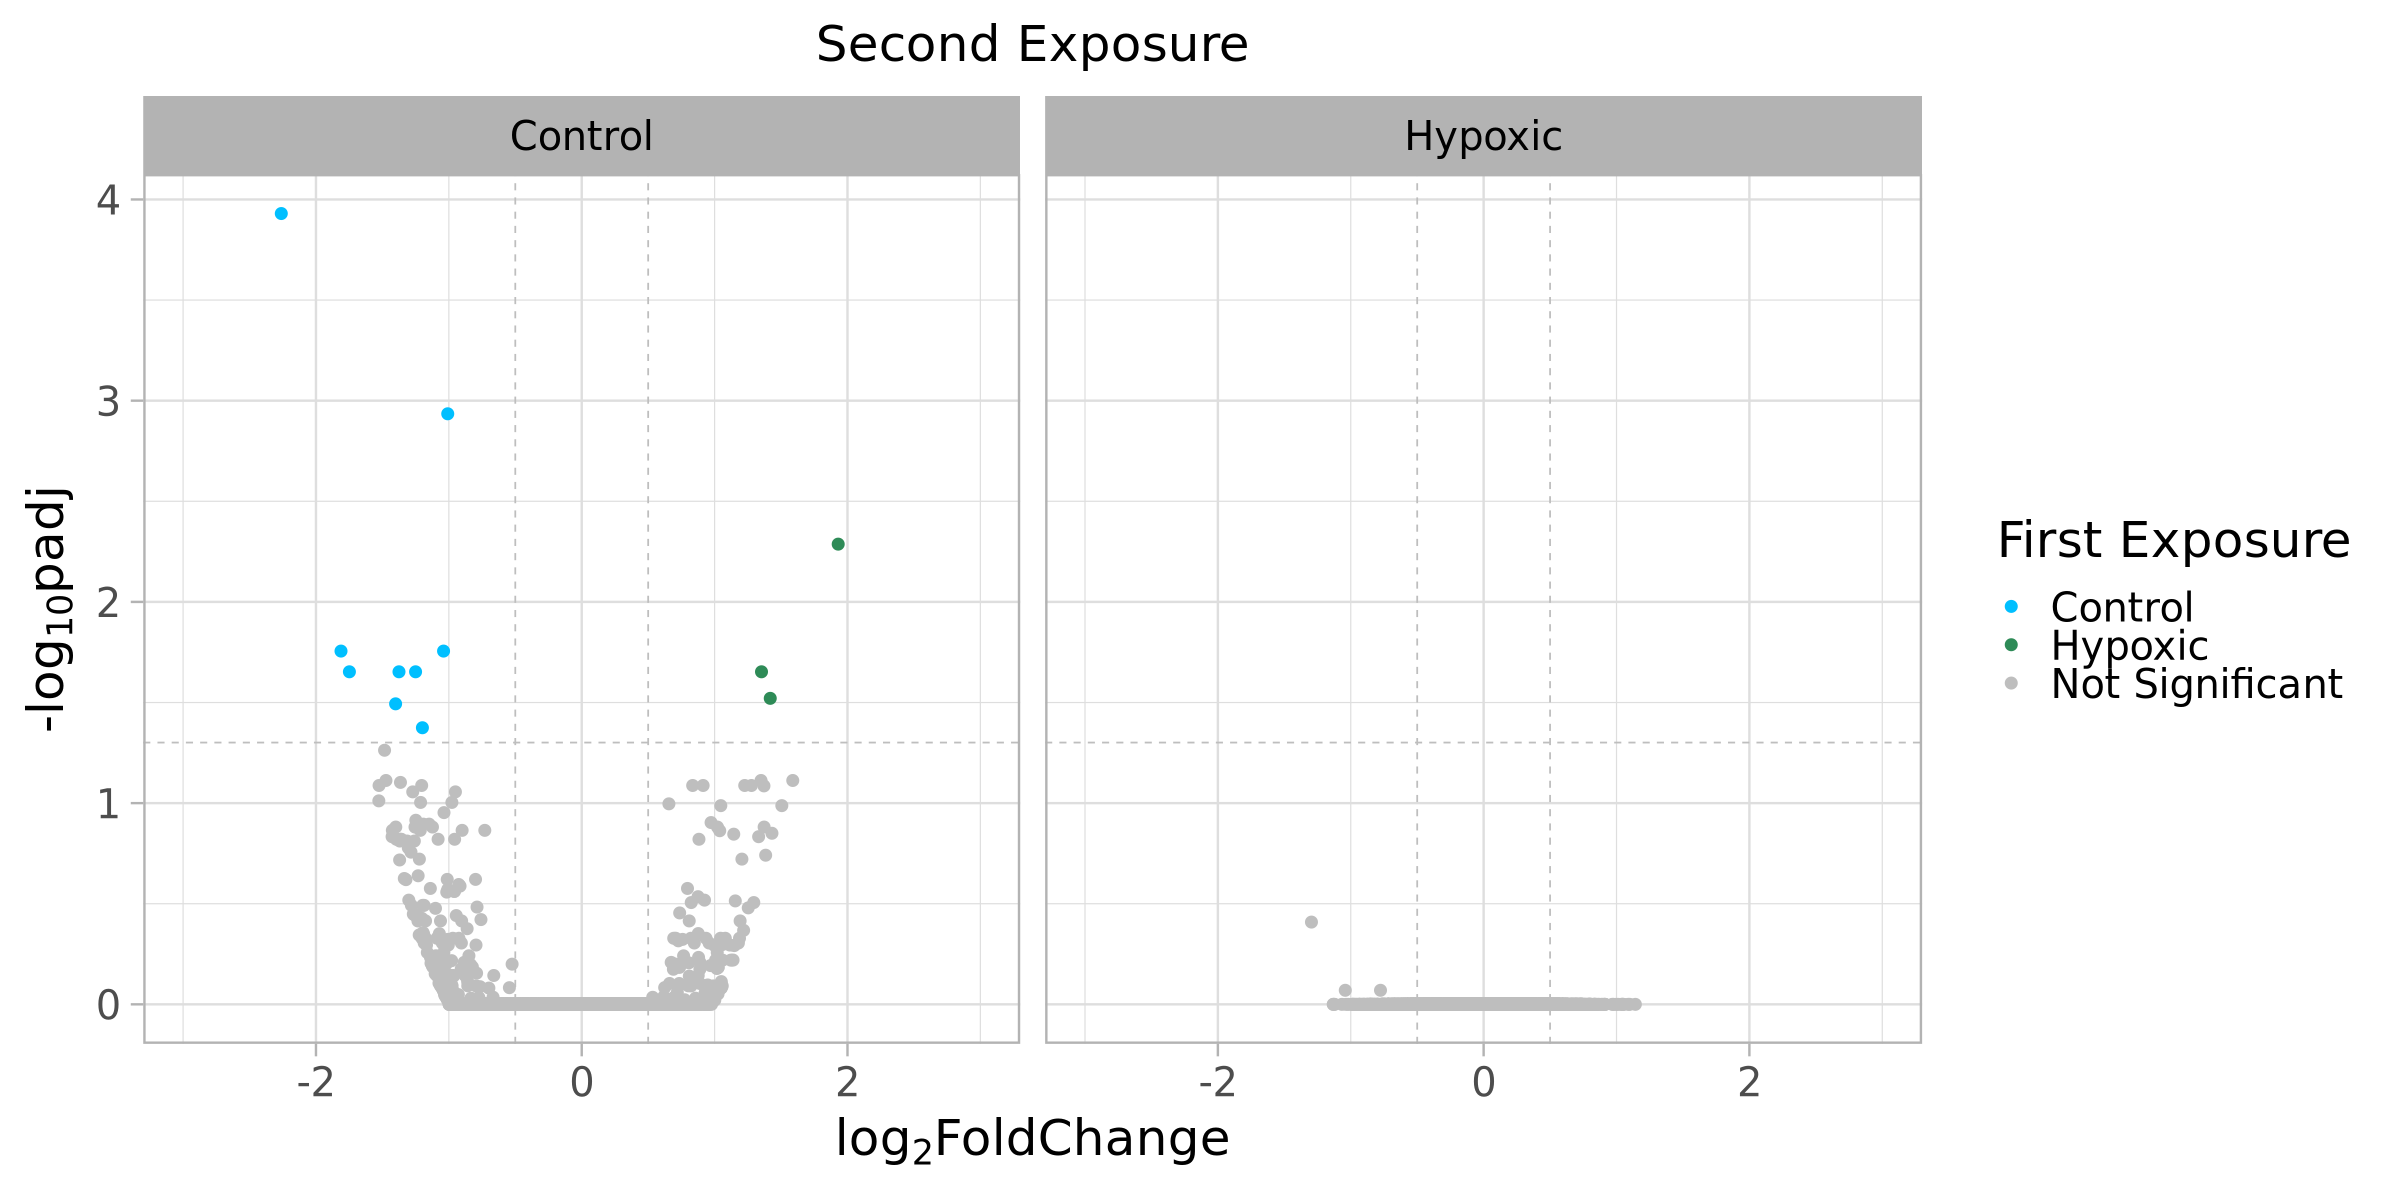

In [58]:
volcano_p2_ce <- ggplot(data = p2_ce_df, aes(x = log2FoldChange, y = -log10(padj), col = more_me_in)) +
geom_vline(xintercept = c(-0.5,0.5), col = "gray", linetype = 'dashed') + # fold change threshold line
facet_grid(~phase2, labeller = as_labeller(grid_names)) +
geom_hline(yintercept = -log10(0.05), col = "gray", linetype = 'dashed') + # padj threshold line
geom_point(size=3) +
scale_color_manual(values = c('deepskyblue','seagreen', 'gray'), labels=c('Control', 'Hypoxic', 'Not Significant')) + 
theme_light(base_size=30) + 
theme(strip.text = element_text(color='black'), plot.subtitle=element_text(hjust=0.5)) + 
labs(subtitle = 'Second Exposure',
     col='First Exposure', 
     x = expression("log"[2]*"FoldChange"), 
     y = expression("-log"[10]*"padj")) +
scale_x_continuous(limits = c(-3,3))

volcano_p2_ce

In [41]:
# saving plot as pdf file

# open pdf file
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures')
pdf('volcano_p2_ce.pdf', width=20, height=10)

# open plot
volcano_p2_ce

# close pdf file
dev.off()

png 
  2

### ggplot2 of DESeq data

now looking at ggplot but faceting by phase 1

looking at phase 1 hypoxia or control CE

In [42]:
# changes size of plots
options(repr.plot.width=20, repr.plot.height=10)

In [43]:
# Allows me to change the name of the facet grid
grid_names <- c(`control` = "Control",
                    `hypoxic` = "Hypoxic")

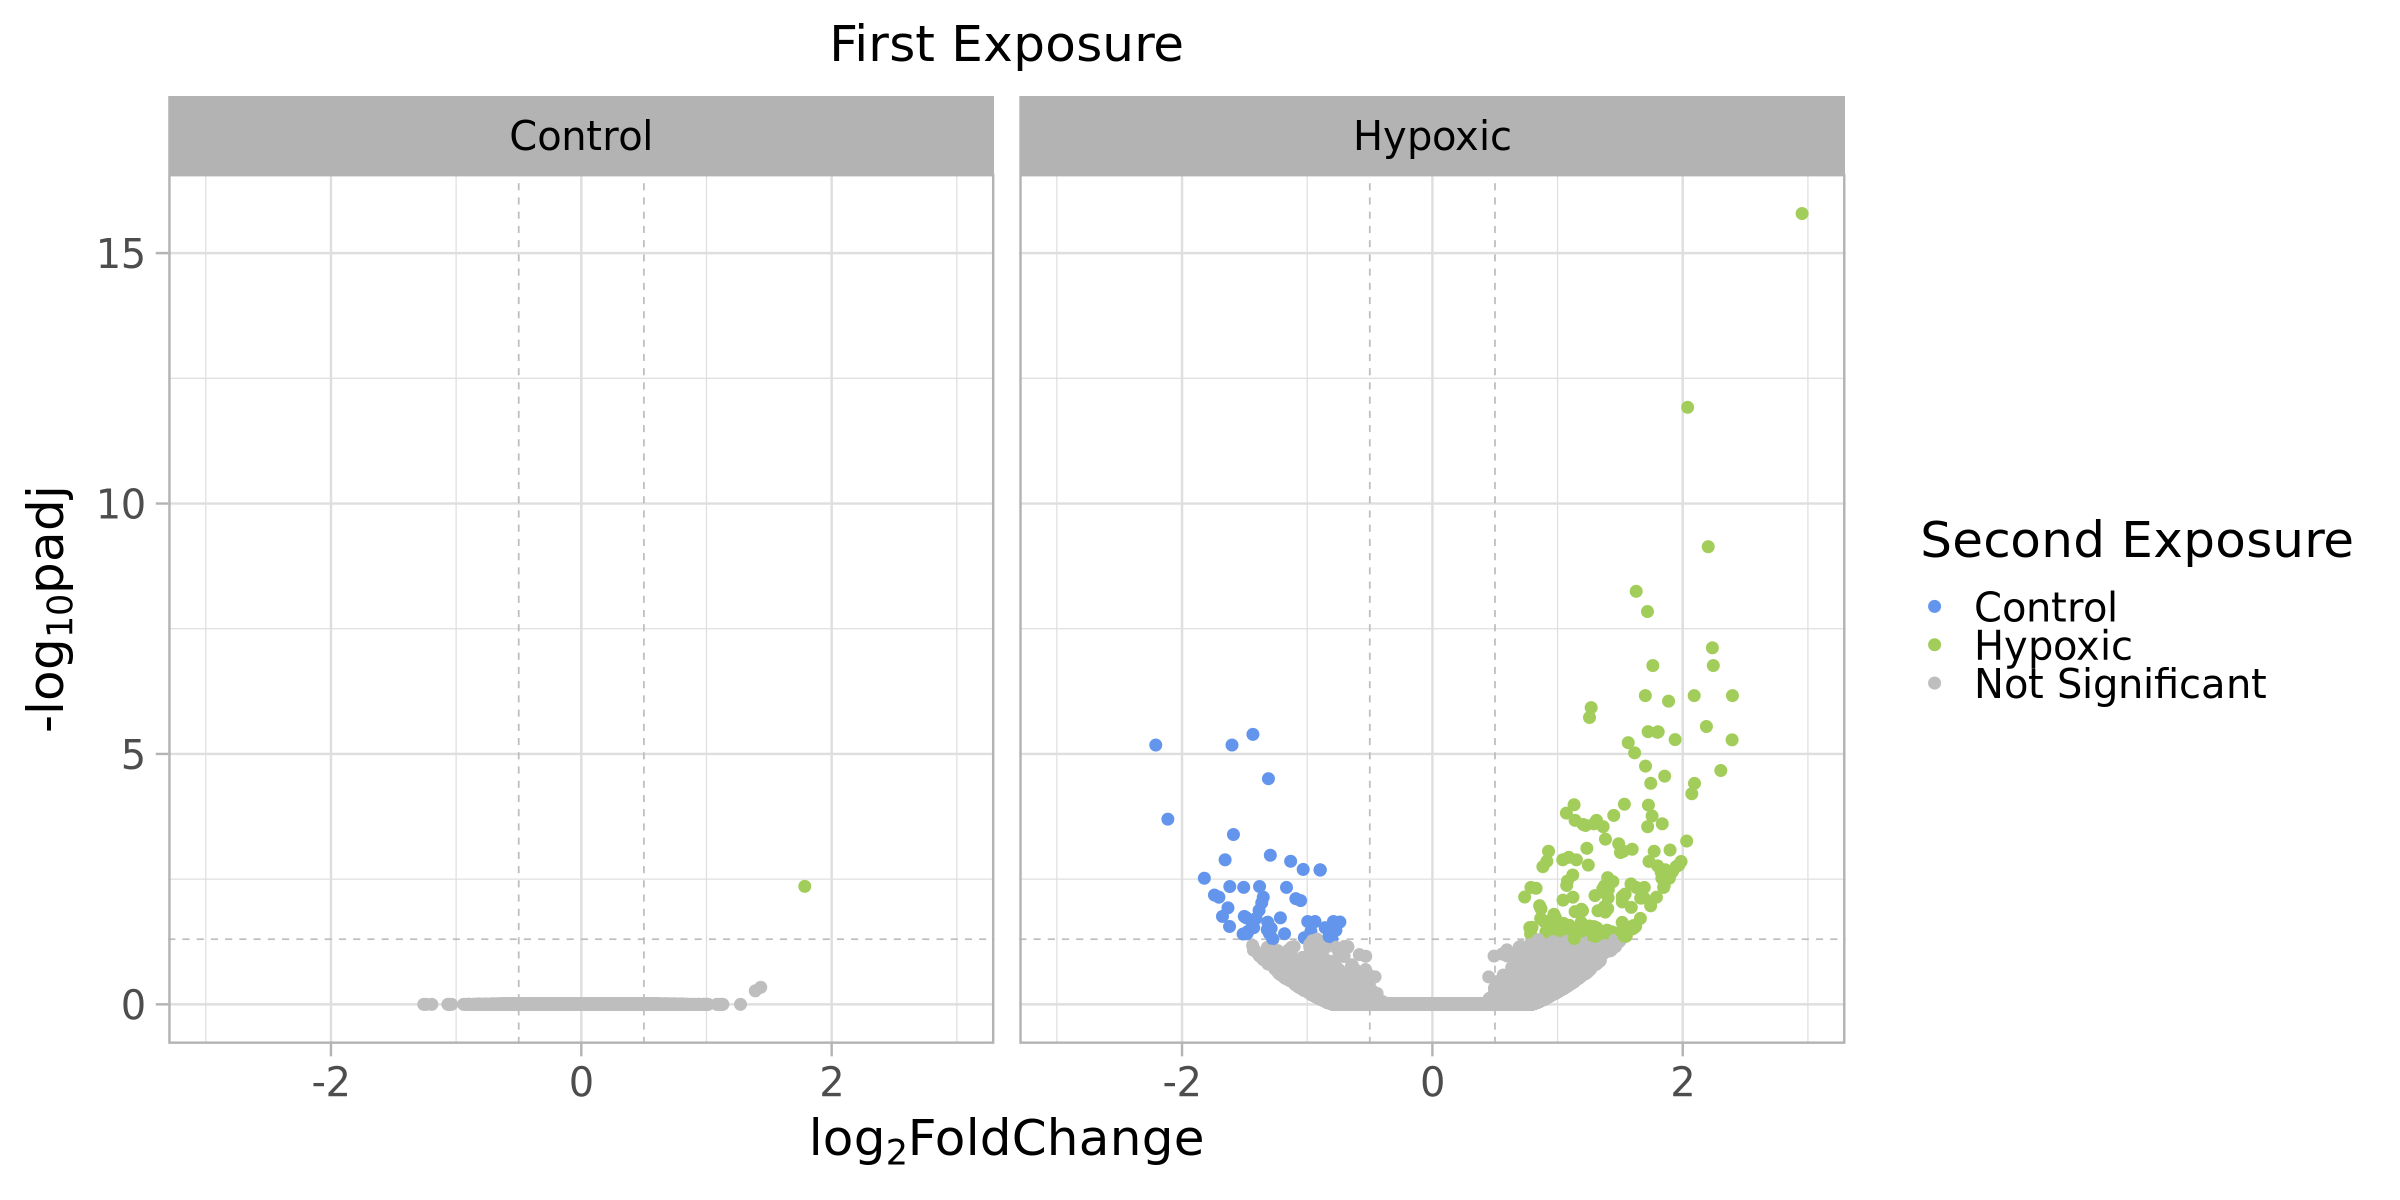

In [44]:
volcano_ce <- ggplot(data = ce_df, aes(x = log2FoldChange, y = -log10(padj), col = more_me_in)) +
geom_vline(xintercept = c(-0.5,0.5), col = "gray", linetype = 'dashed') + # fold change threshold line
facet_grid(~phase1, labeller = as_labeller(grid_names)) +
geom_hline(yintercept = -log10(0.05), col = "gray", linetype = 'dashed') + # padj threshold line
geom_point(size=3) +
scale_color_manual(values = c('cornflowerblue','darkolivegreen3', 'gray'), labels=c('Control', 'Hypoxic', 'Not Significant')) + 
theme_light(base_size=30) + 
theme(strip.text = element_text(color='black'), plot.subtitle=element_text(hjust=0.5)) + 
labs(subtitle = 'First Exposure',
     col='Second Exposure', 
     x = expression("log"[2]*"FoldChange"), 
     y = expression("-log"[10]*"padj")) +
scale_x_continuous(limits = c(-3,3))

volcano_ce

In [45]:
# saving plot as pdf file

# open pdf file
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures')
pdf('volcano_ce.pdf', width=20, height=10)

# open plot
volcano_ce

# close pdf file
dev.off()

png 
  2

### DMGs of the other combinations 
Now that I've generated plots and done DESeq for the three 'more important' treatment comparisons, going back to get the DMGs for all the other combinations to fill out DMGs table

checking out **effects of phase 1, ignoring phase 2**

In [46]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 607 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase1_control_vs_both" "Phase1_hypoxic_vs_both"
[4] "Phase1_warm_vs_both"

**Phase 1 both vs. control**

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13538 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 601, 4.4%
low counts [2]     : 6, 0.044%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



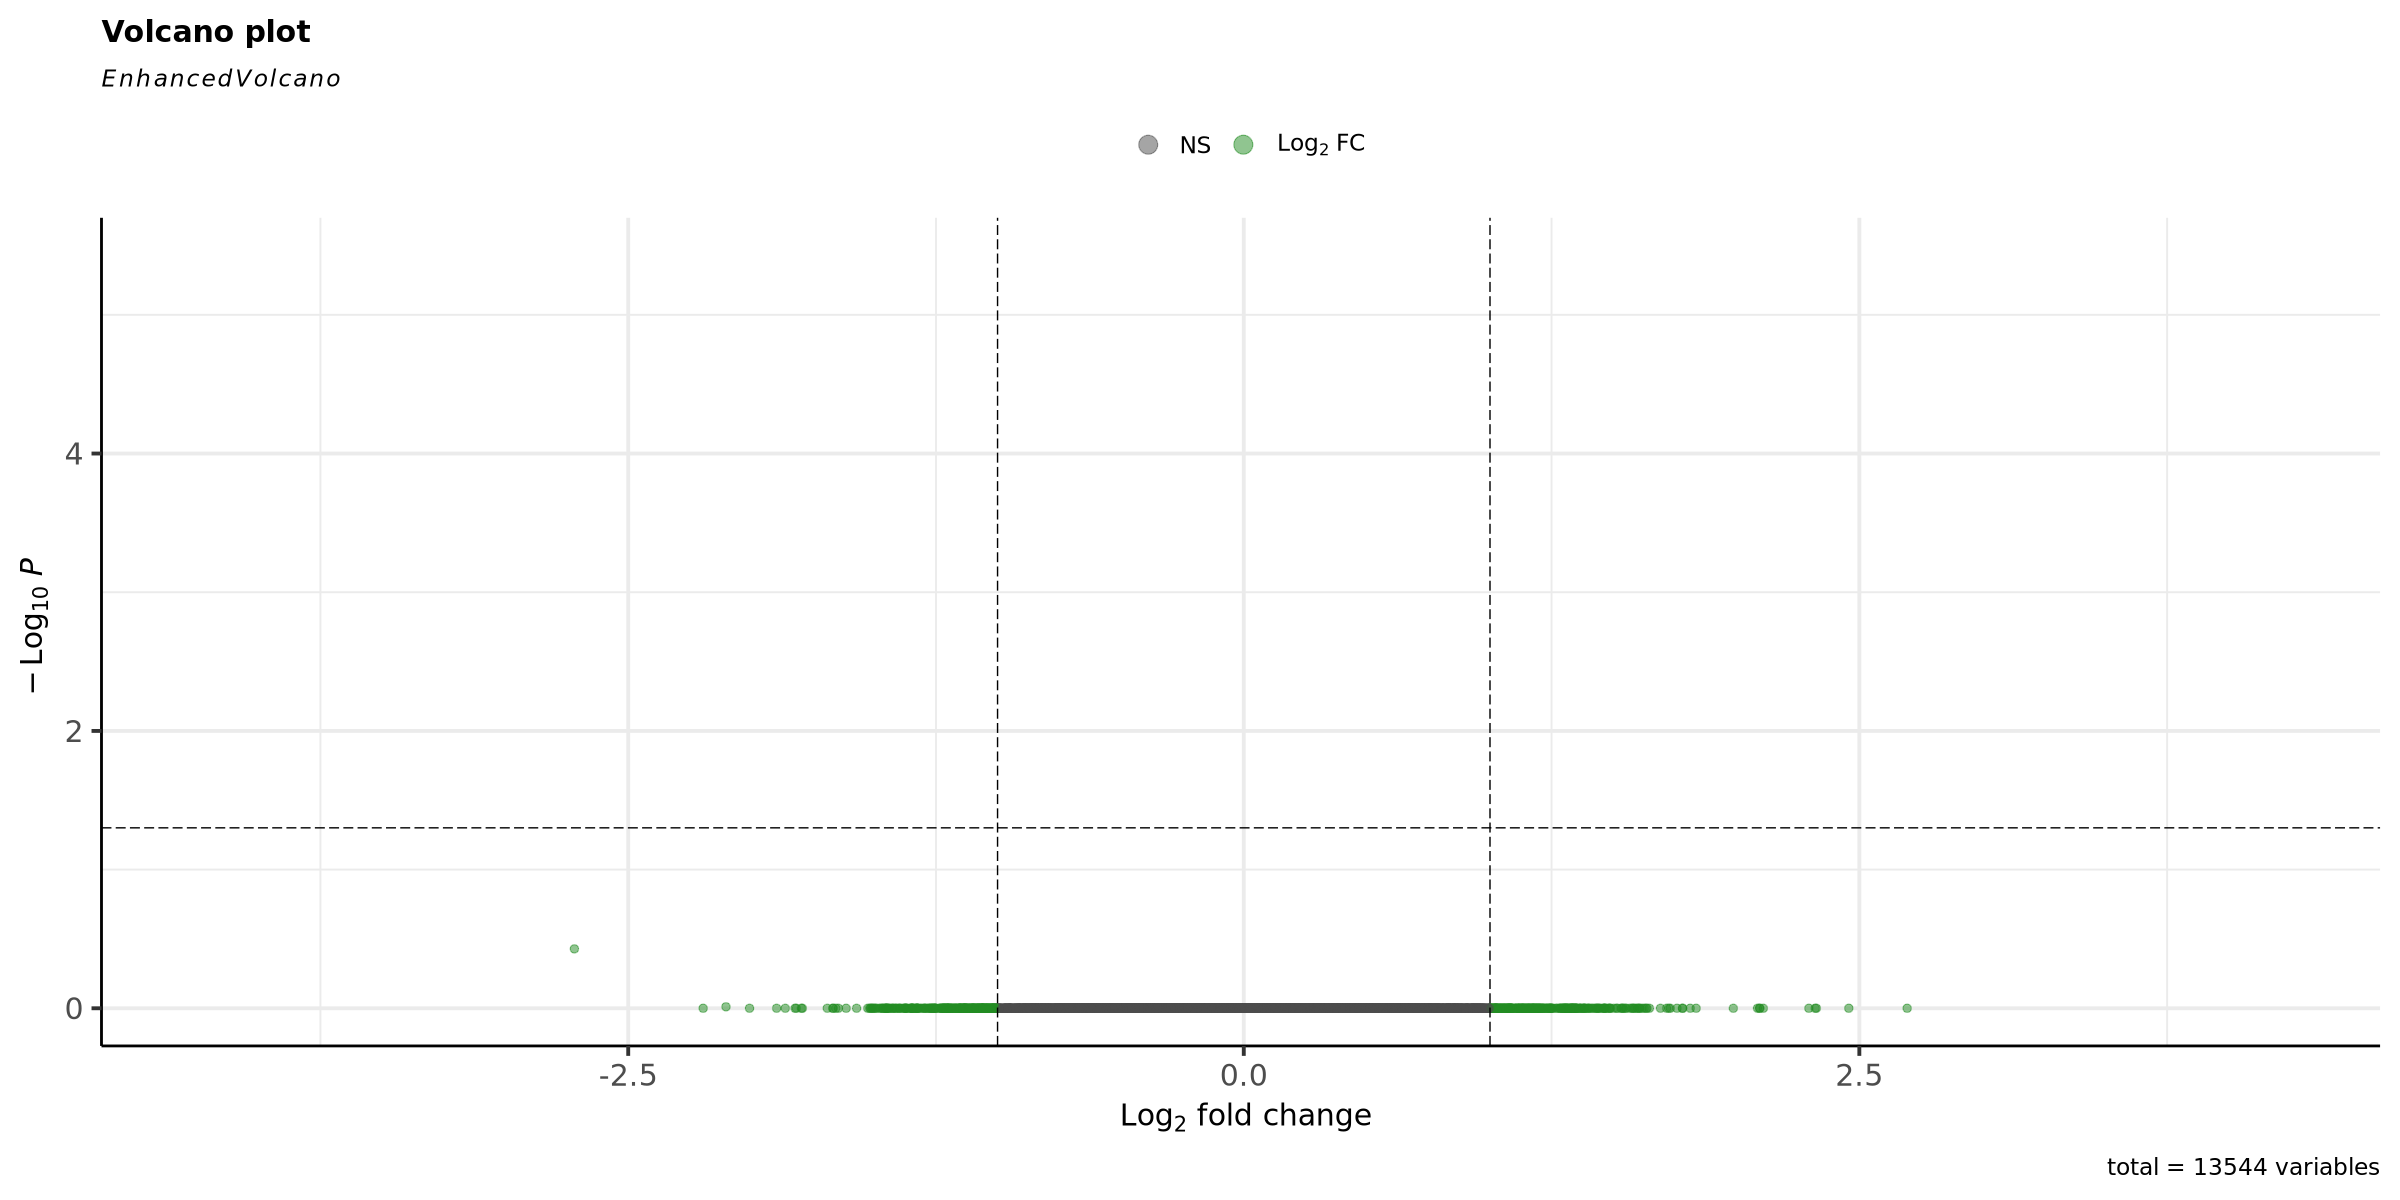

In [47]:
contrast4 <- c("Phase1", "both", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p1bc<-lfcShrink(p1_dds, # dds object
                      contrast = contrast4, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1bc)

EnhancedVolcano(ls_p1bc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

checking out **effects of phase 2, ignoring phase 1**

In [48]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2_dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ Phase2)
p2_dds=DESeq(p2_dds)
resultsNames(p2_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 913 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase2_control_vs_both" "Phase2_hypoxic_vs_both"

**Phase 2 both vs. control**

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13538 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 70, 0.52%
LFC < -0.25 (down) : 1, 0.0074%
outliers [1]       : 907, 6.7%
low counts [2]     : 5319, 39%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



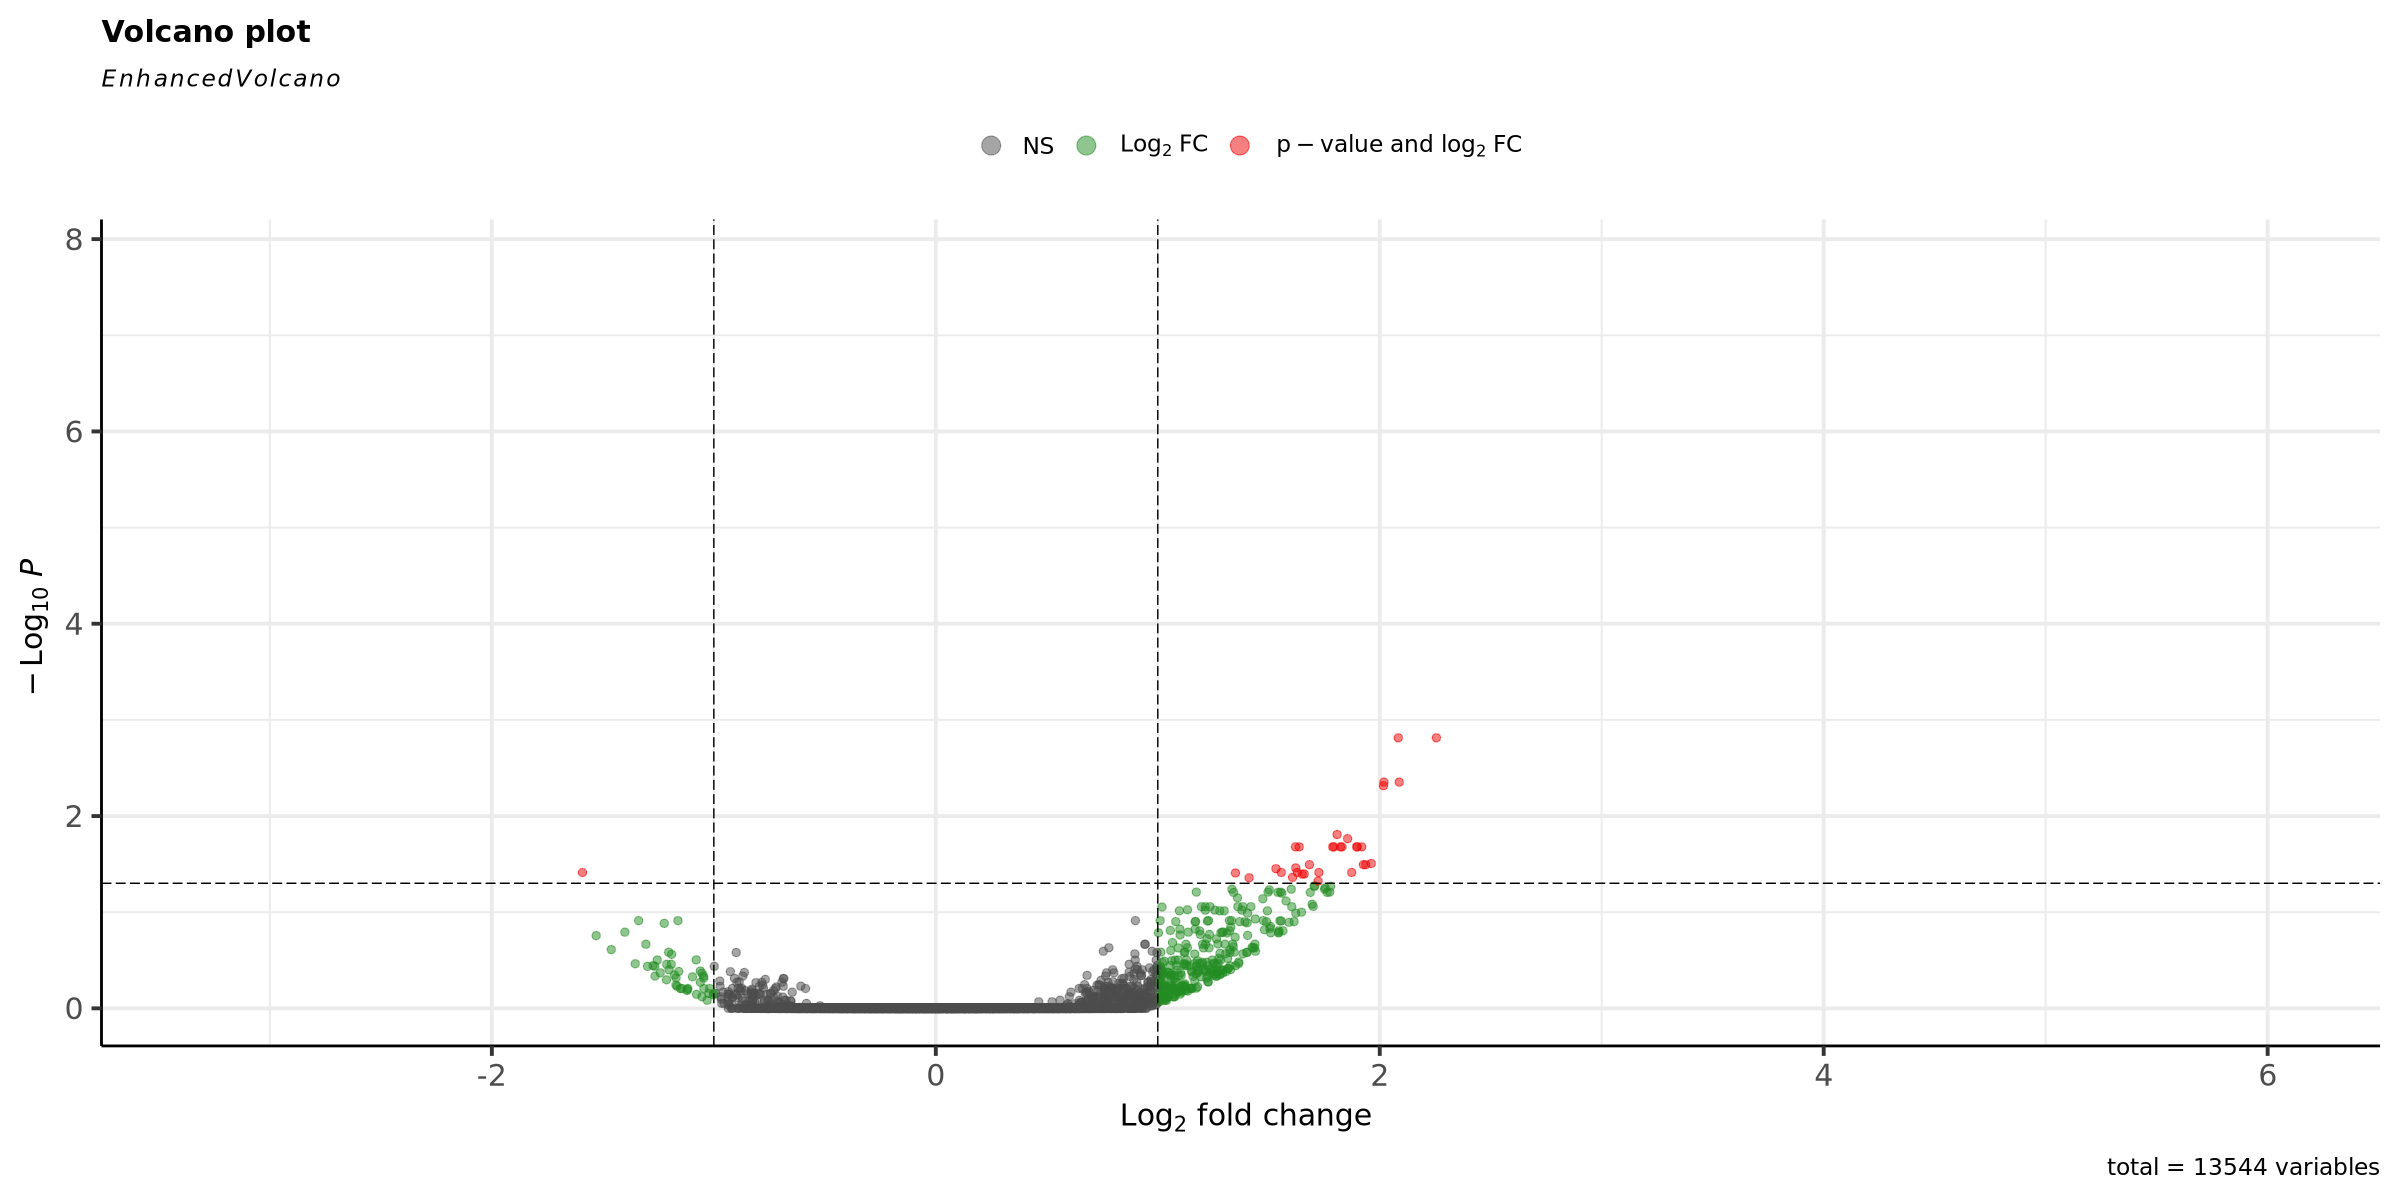

In [49]:
contrast5 <- c("Phase2", "both", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2bc<-lfcShrink(p2_dds, # dds object
                      contrast = contrast5, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2bc)

EnhancedVolcano(ls_p2bc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

**Phase 2 both vs. hypoxic**

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13538 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 8, 0.059%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 907, 6.7%
low counts [2]     : 11609, 86%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



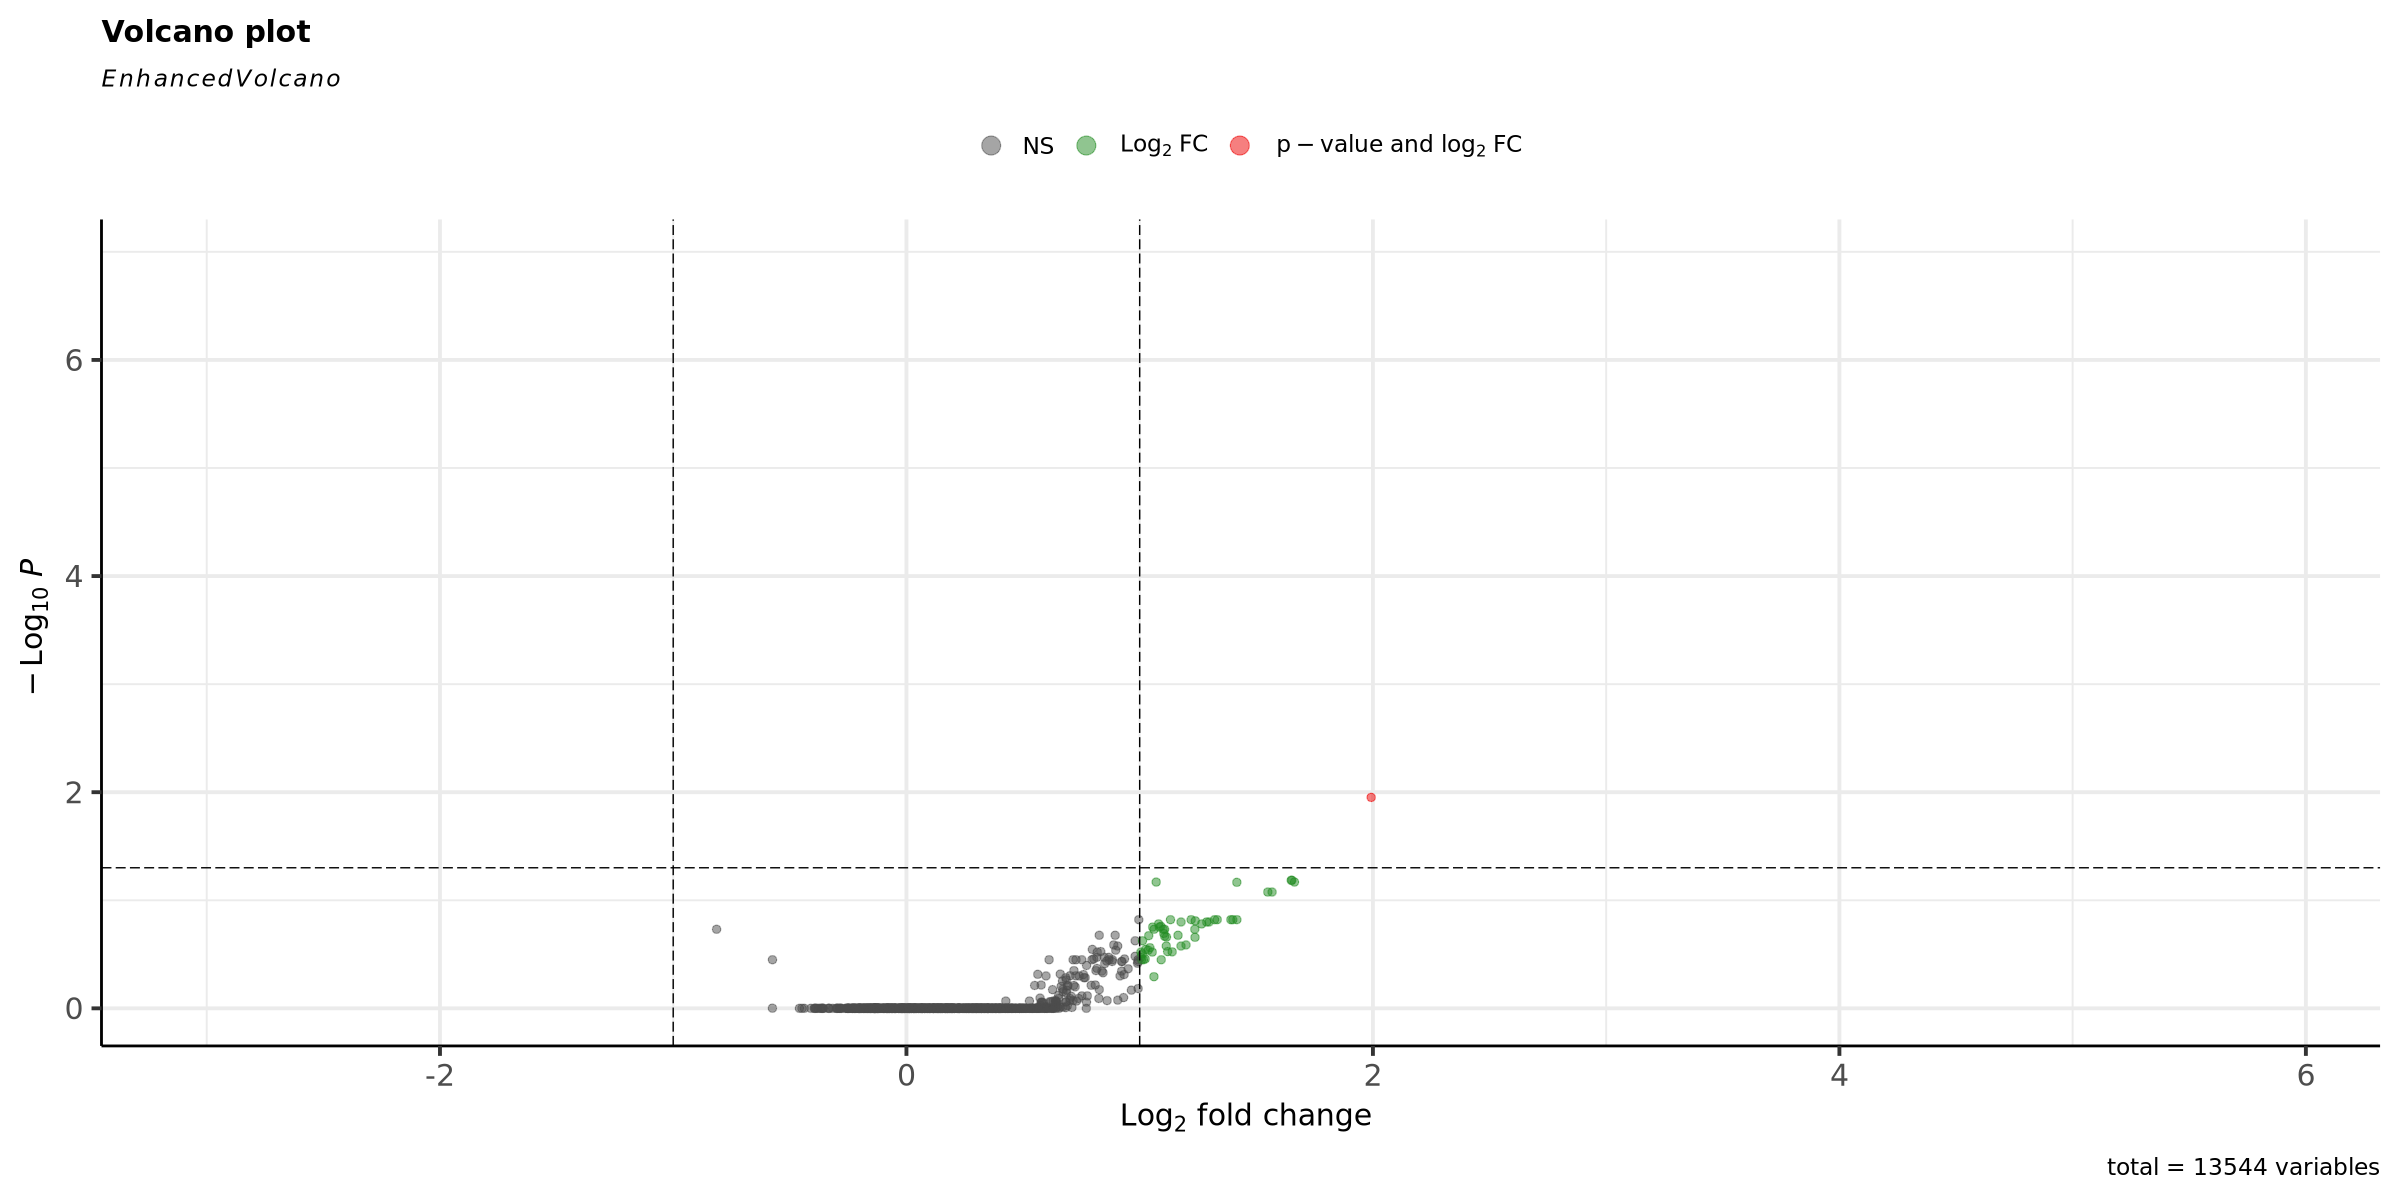

In [50]:
contrast6 <- c("Phase2", "both", "hypoxic")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2hb<-lfcShrink(p2_dds, # dds object
                      contrast = contrast6, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA

summary(ls_p2hb)

EnhancedVolcano(ls_p2hb, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

**given phase 2, what are the effects of phase 1**

filtering first for phase2=control

In [51]:
control_meta <- filter(meta, meta$Phase2 == 'control')
control_counts <- counts2[,colnames(counts2) %in% rownames(control_meta)]

head(control_meta, 15)
head(control_counts)

,Phase1,Phase2
,<chr>,<chr>
BBB-WBO-B21,hypoxic,control
BBB-WBV-B70,hypoxic,control
BBO-WBO-B16,hypoxic,control
BBO-WBV-B64,hypoxic,control
BBY-WBG-B42,hypoxic,control
WBB-WBV-W69,control,control
WBG-WBG-W44,control,control
WBO-WBV-W64,control,control
WBV-WBO-W23,control,control


,BBB-WBO-B21,BBB-WBV-B70,BBO-WBO-B16,BBO-WBV-B64,BBY-WBG-B42,WBB-WBV-W69,WBG-WBG-W44,WBO-WBV-W64,WBV-WBO-W23,WBV-WBR-W12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,2,2,2,0,0,3,0,1,0,0
LOC111109452,0,0,1,1,2,0,0,7,1,0
LOC111124802,597,453,502,434,110,418,76,305,120,57
LOC111101273,173,146,171,158,45,132,49,143,45,18
LOC111101250,253,255,327,269,49,212,56,201,96,24
LOC111101262,645,634,647,677,108,453,102,422,146,52


In [52]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2c_dds <- DESeqDataSetFromMatrix(countData = control_counts,
                              colData = control_meta, 
                              design = ~ Phase1)
p2c_dds=DESeq(p2c_dds)
resultsNames(p2c_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13322 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 10, 0.075%
LFC < -0.25 (down) : 19, 0.14%
outliers [1]       : 286, 2.1%
low counts [2]     : 4972, 37%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



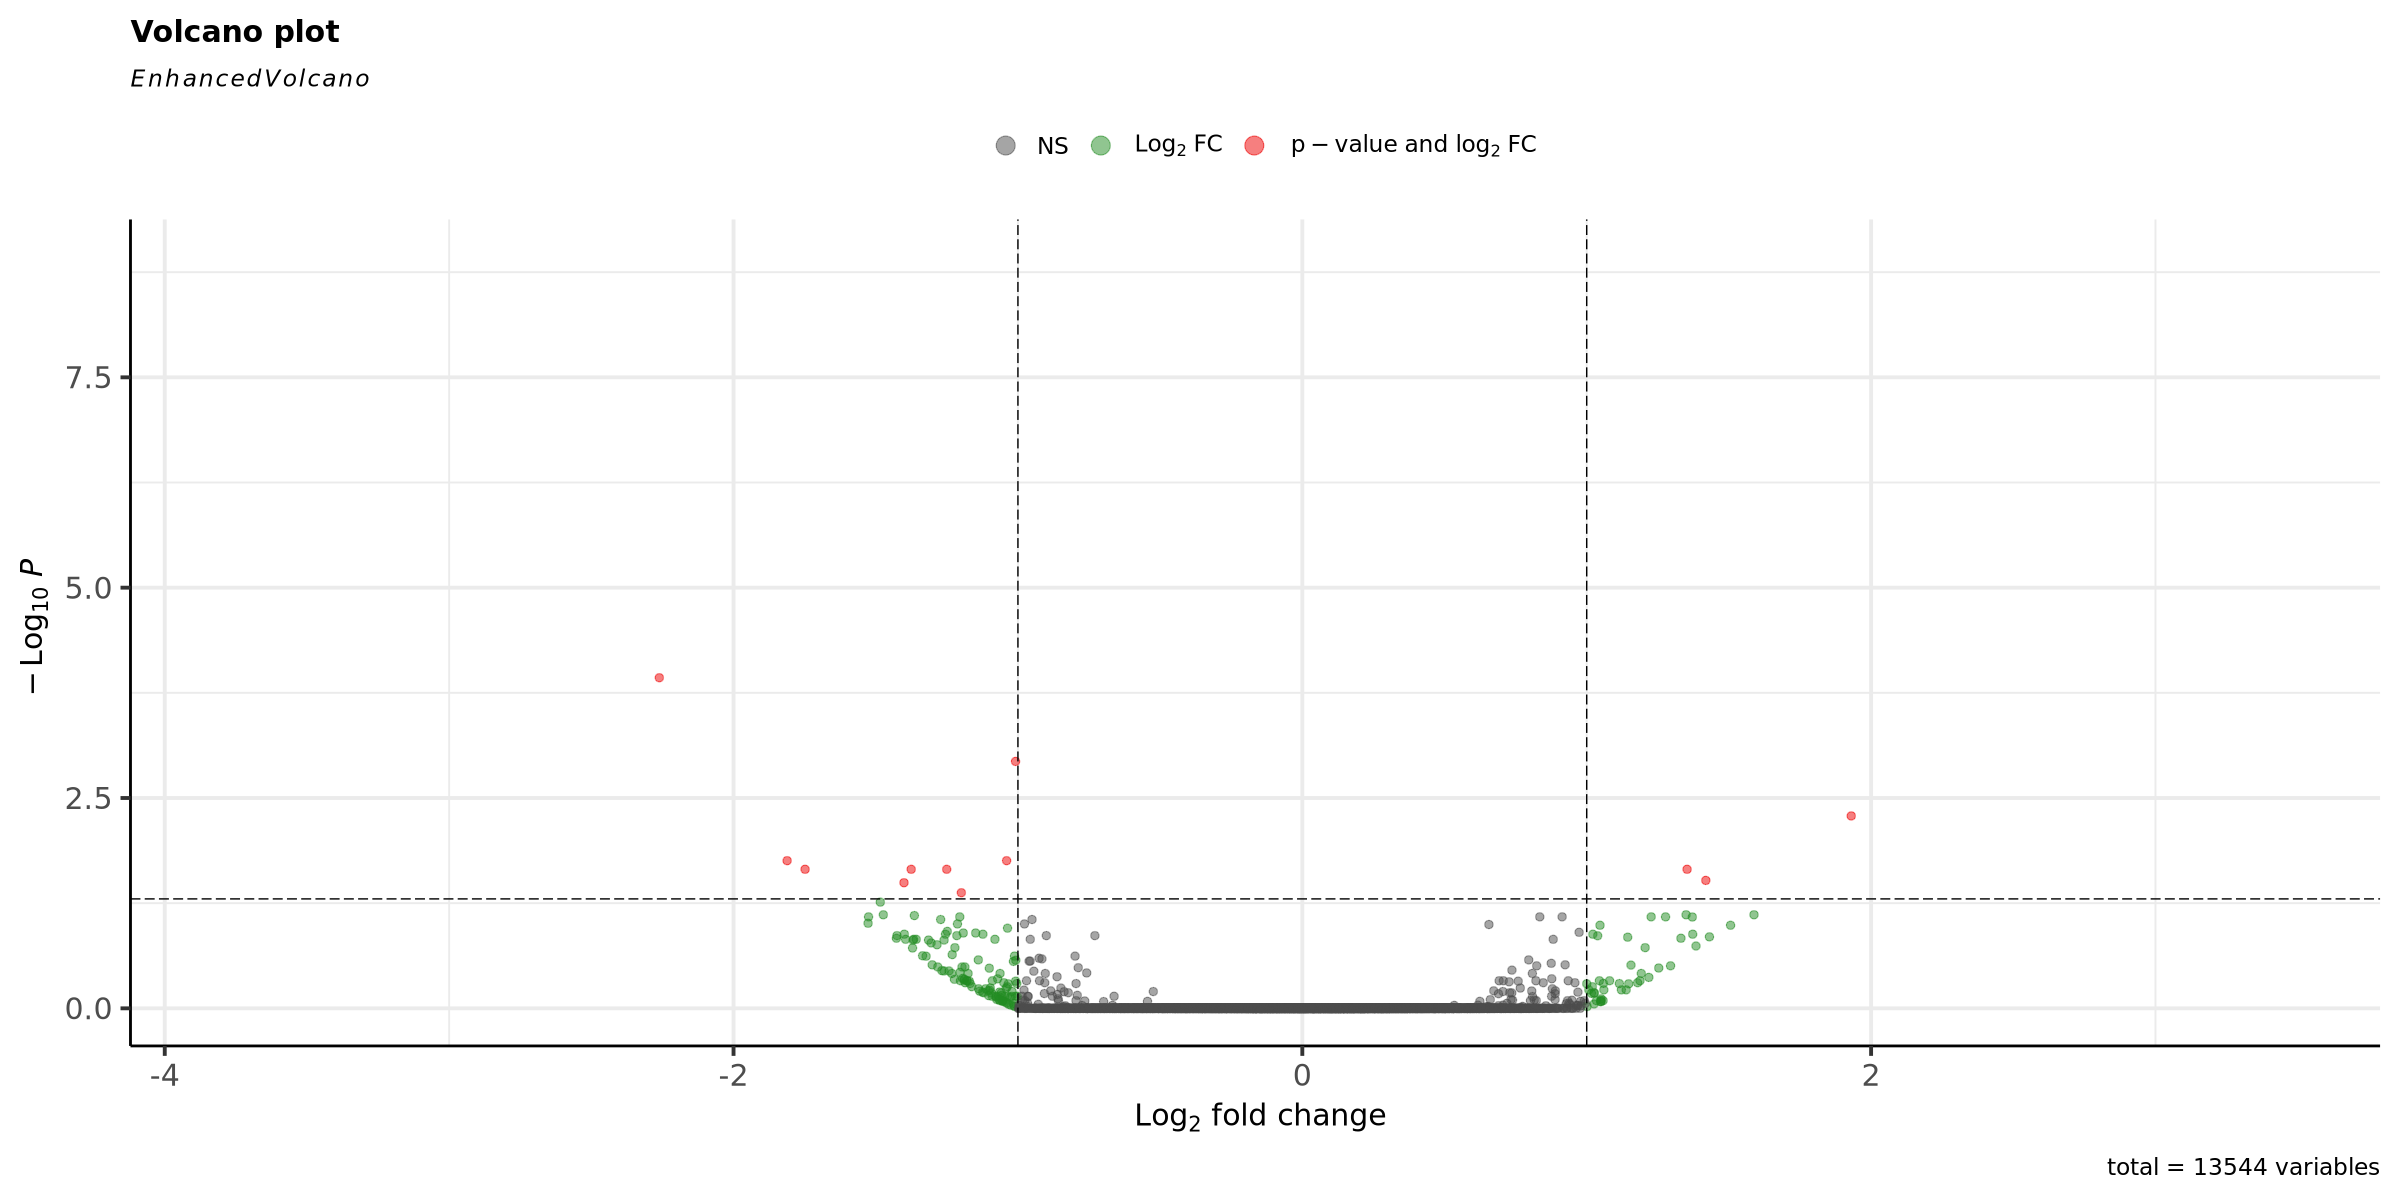

In [53]:
contrast6 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2c<-lfcShrink(p2c_dds, # dds object
                      contrast = contrast6, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2c)

EnhancedVolcano(ls_p2c, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

**phase 2 = hypoxia**

In [54]:
hypoxic_meta <- filter(meta, meta$Phase2 == 'hypoxic')
hypoxic_counts <- counts2[,colnames(counts2) %in% rownames(hypoxic_meta)]

head(hypoxic_meta)
head(hypoxic_counts)

,Phase1,Phase2
,<chr>,<chr>
BBO-BBO-B16,hypoxic,hypoxic
BBO-BBY-B27,hypoxic,hypoxic
BBR-BBB-B50,hypoxic,hypoxic
BBR-BBG-B38,hypoxic,hypoxic
BBR-BBY-B26,hypoxic,hypoxic
WBG-BBB-W56,control,hypoxic


,BBO-BBO-B16,BBO-BBY-B27,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,WBG-BBB-W56,WBO-BBR-W03,WBR-BBY-W25,WBY-BBV-W65,WBY-BBY-W30
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,0,0,0,0,1,1,0,0,0,1
LOC111109452,0,0,10,12,0,1,0,0,1,2
LOC111124802,408,244,187,336,311,455,20,122,289,202
LOC111101273,115,75,64,115,137,127,8,43,87,81
LOC111101250,257,118,115,141,184,261,7,91,254,109
LOC111101262,502,364,246,389,355,485,40,184,387,251


In [55]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2h_dds <- DESeqDataSetFromMatrix(countData = hypoxic_counts,
                              colData = hypoxic_meta, 
                              design = ~ Phase1)
p2h_dds=DESeq(p2h_dds)
resultsNames(p2h_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13371 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 190, 1.4%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



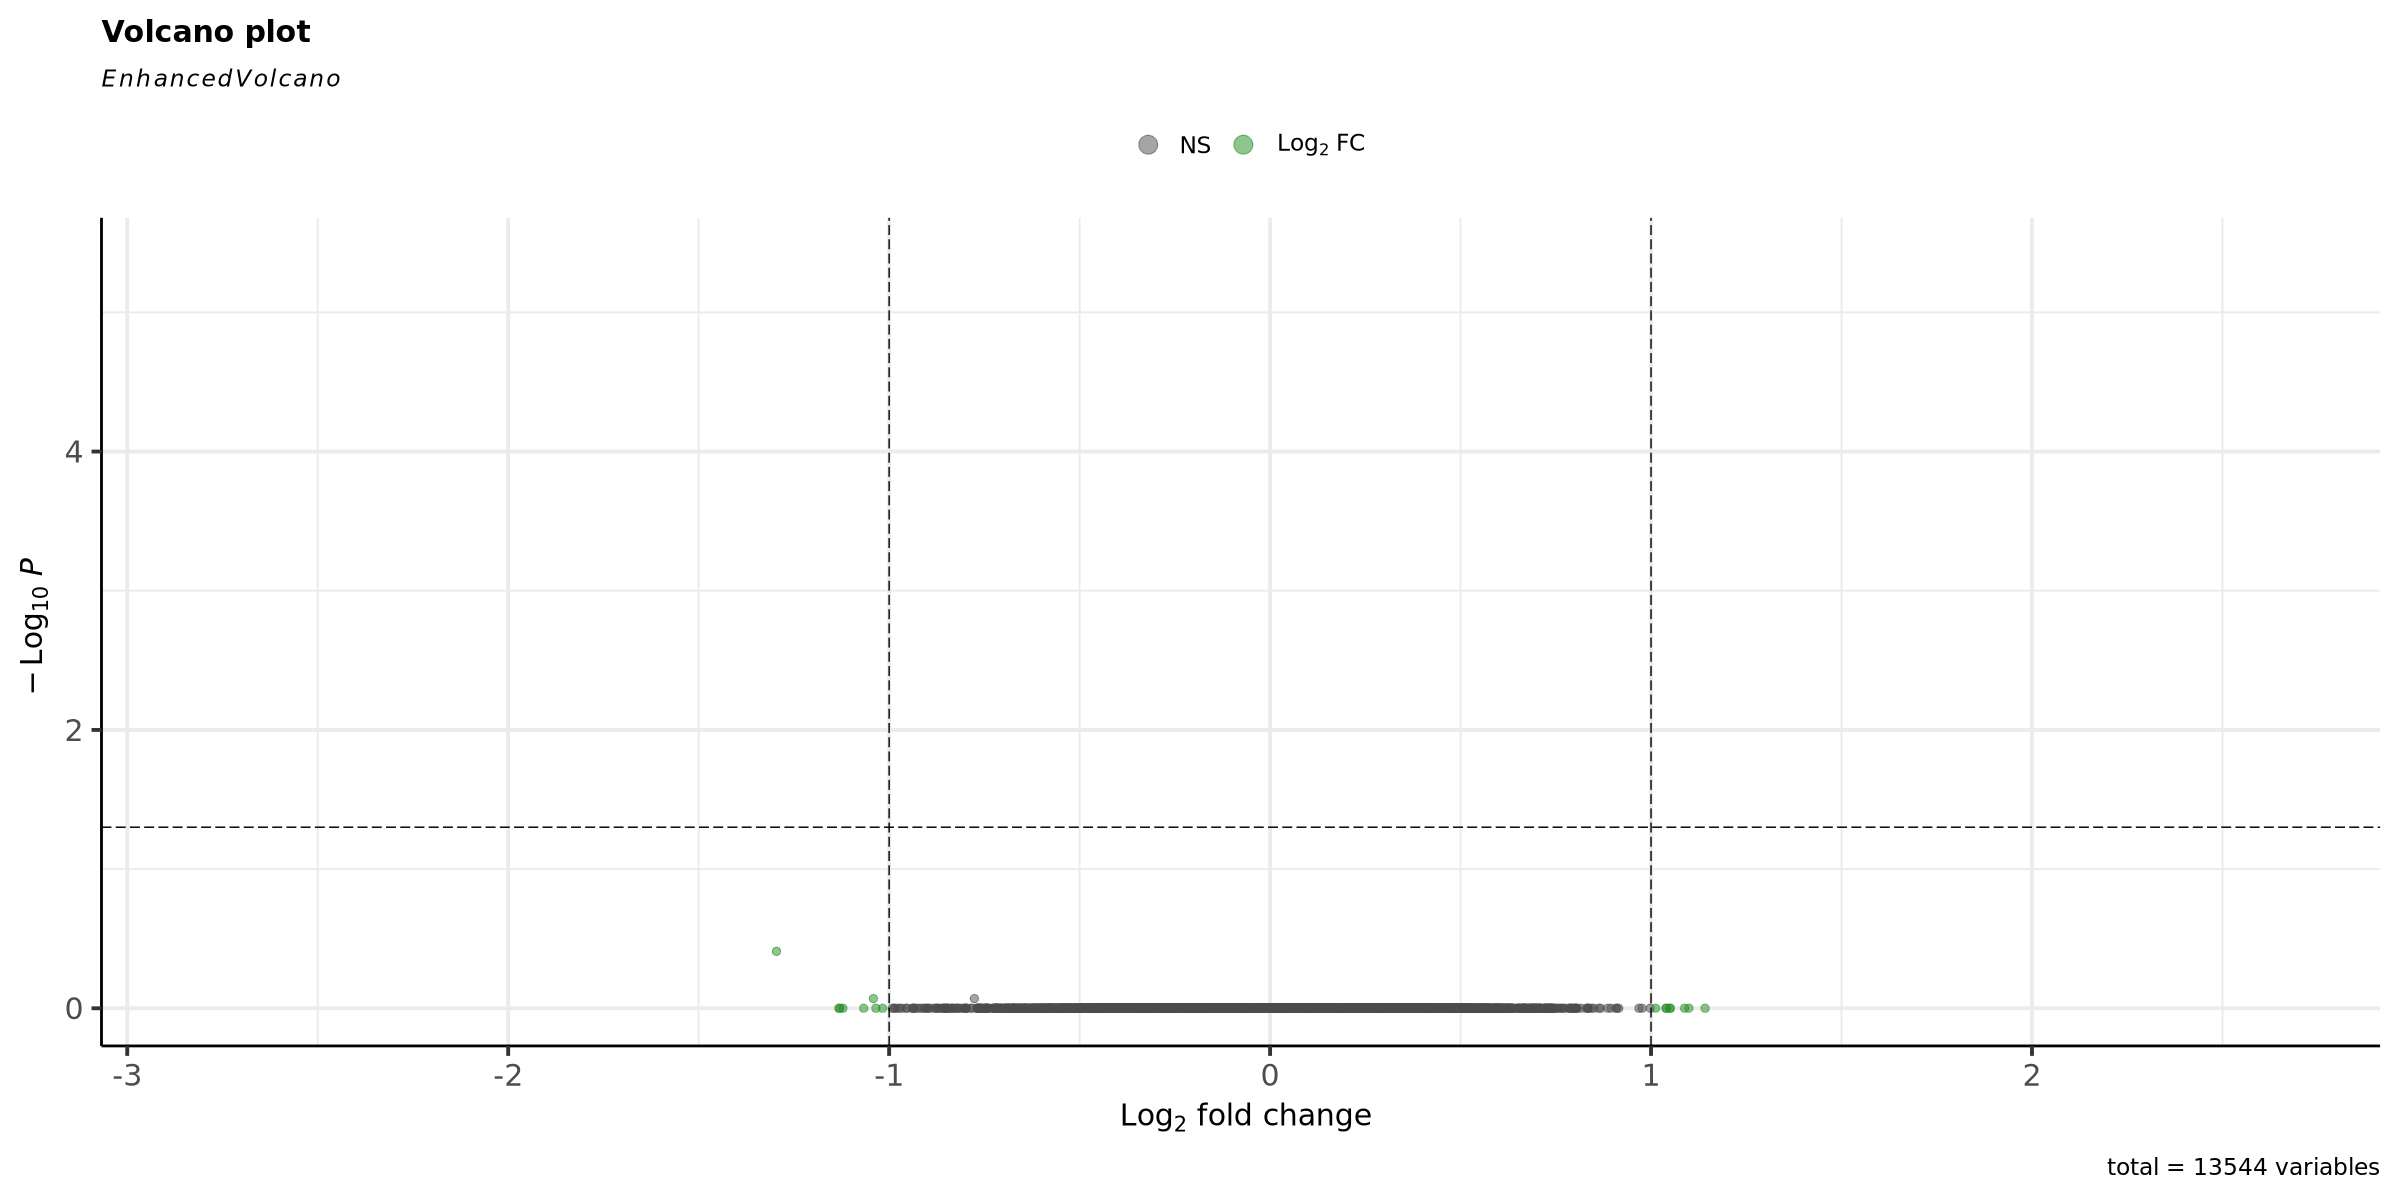

In [56]:
contrast7 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2h<-lfcShrink(p2h_dds, # dds object
                      contrast = contrast7, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2h)

EnhancedVolcano(ls_p2h, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)